In [297]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, Cropping2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, rmsprop
from keras import losses
from keras.layers import MaxPooling2D, concatenate, Add
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

import os
import shutil

import joblib

patch_size = 128

category = True

import imgaug
import keras.utils

import numpy as np
import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, Lambda
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, Cropping2D
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, concatenate, Add
import keras.backend as K


import keras.utils
from keras.engine.topology import Layer

def nvidia_unet(patch_size=128):
    input_ = Input((patch_size, patch_size, 3))
    skips = []
    output = input_
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [16, 32, 64, 64, 64, 64, 64]):
        skips.append(output)
        print(output.shape)
        output= Conv2D(filters // 2, (shape, shape), strides=2, padding="same", activation="relu")(output)
        #output = BatchNormalization()(output)
        #if shape != 7:
        #   output = BatchNormalization()(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [64, 64, 64, 64,32, 16, 2]):
        output = keras.layers.UpSampling2D()(output)
        
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        
        if filters != 2:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(filters // 2 if filters != 2 else 2, (shape, shape), activation=activation, padding="same")(output)
        
        
            
        if filters != 2:
            output = BatchNormalization(momentum=.9)(output)
    assert len(skips) == 0
    return Model([input_], [output])
models = [nvidia_unet() for _ in range(2)]
[model.compile(optimizer=keras.optimizers.adam(), loss= "mean_squared_error") for model in models]
loss = [[] for _ in range(2)]

(?, 128, 128, 3)
(?, 64, 64, 16)
(?, 32, 32, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)
(?, 2, 2, 64)
(?, 128, 128, 3)
(?, 64, 64, 16)
(?, 32, 32, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)
(?, 2, 2, 64)


In [343]:
import cv2
import random
from PIL import Image
web_images_Dir = "../../webgrid/image_uploads/"
web_static_pictures = os.listdir(web_images_Dir)[1:]

def true_random_web_image():
    p = random.choice(web_static_pictures)
    return np.rot90(np.array(Image.open(web_images_Dir + p)), 3)
oldmodel = keras.models.load_model("../light_diverse_linefinder")
for _ in range(2):
    try:
        imgs = [true_random_web_image()[::4, ::4] for _ in range(120)]
        inputs = []
        outputs = []
        for img in imgs:
            #i, o = segment3_getblocks4train(img)
            
            i = img[ :, :, :3]
            #print(i.shape)
            i = i.reshape(1, 128, 128, 3)
            i = np.concatenate([i, np.flip(i, 1)])
            i = np.concatenate([i, np.flip(i, 2)])
            #print(i.shape)
            o = oldmodel.predict(i / 255.)
            #print(o.shape)
            
            #print(o.shape)
            scale = np.random.uniform(-1.4, 1.4, (i.shape[0], 1, 1, 1))


            inputs.append((i / 255.) ** ( 2.5 **scale))
            outputs.append(o)
        inputs = np.concatenate(inputs)
        outputs = np.concatenate(outputs)
        #model.fit(inputs, outputs)
    except OSError as e:
        print(e)
    finally:
        if type(inputs) is list:
            inputs = np.concatenate(inputs)
            outputs = np.concatenate(outputs)

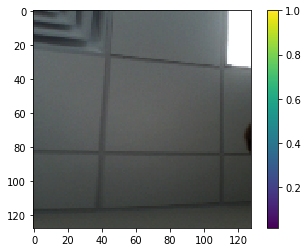

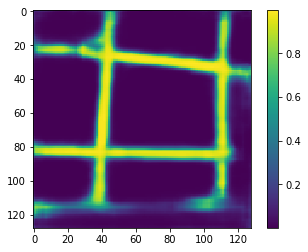

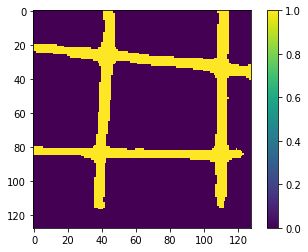

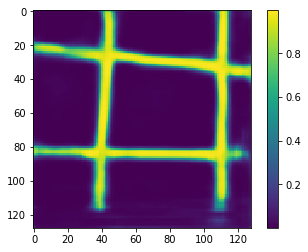

In [353]:
i = np.random.randint(230)
plt.imshow(inputs[i, :, :])
plt.colorbar()
plt.show()
plt.imshow(outputs[i, :, :, 0])
plt.colorbar()
plt.show()
plt.imshow(1.0 * (models[0].predict(inputs[i:i+1])[0, :, :, 0] > .5))
plt.colorbar()
plt.show()
plt.imshow(1.0 * (models[0].predict(inputs[i:i+1])[0, :, :, 0]))
plt.colorbar()
plt.show()

In [4]:
from PIL import Image
import numpy as np
import os
pictures = {name: np.array(Image.open("../manual_segmentations/"+name)) for name in os.listdir("../manual_segmentations/")}
pictures = np.array(list(pictures.values()))

In [5]:
def dialateStack(array, iterations):
    return np.array([scipy.ndimage.binary_dilation(y_e, iterations=iterations) for y_e in array])

import scipy
from PIL import Image
import numpy as np
import os
testpictures = {name: np.array(Image.open("../test_set/manual_segmentations/"+name)) for name in os.listdir("../test_set/manual_segmentations/")}
testpictures = np.array(list(testpictures.values()))

testdata = testpictures[:, ::2, ::2, :3] / 255.
testclasses = 1 - testpictures[:, :, :, 3:] / 255
width = 14
test_y_edge = dialateStack(testclasses, width)[:, ::2, ::2] * 1.0

t_final_x = []
t_final_y = []
for i in range(len(testdata)):

    
    t_final_x.append(cv2.resize(testdata[i], (128, 128)))
    t_final_y.append(cv2.resize(test_y_edge[i], (128, 128)))
testdata_ready = np.array(t_final_x)
testclasses_ready = np.array(t_final_y)

testclasses_ready = np.expand_dims(testclasses_ready, -1)
testclasses_ready = np.concatenate([testclasses_ready, 1-testclasses_ready], -1)


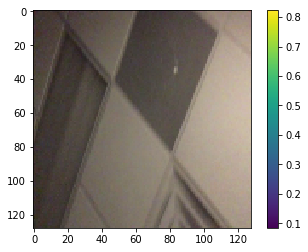

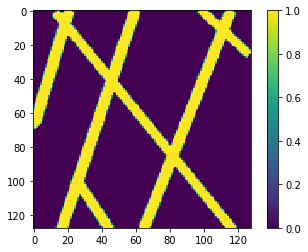

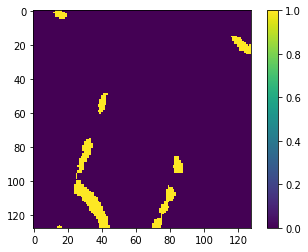

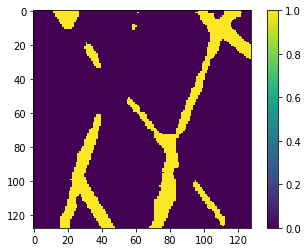

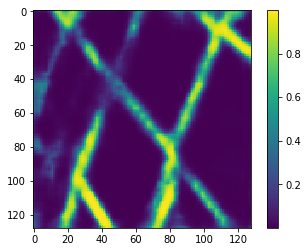

IndexError: list index out of range

In [374]:
for j in [5]:
    modelt = models[1]
    #testdata_ready *= 255
    i = np.random.randint(len(testdata_ready))
    plt.imshow(testdata_ready[i, :, :])
    plt.colorbar()
    plt.show()
    plt.imshow(testclasses_ready[i, :, :, 0])
    plt.colorbar()
    plt.show()
    plt.imshow(1.0 * (oldmodel.predict(testdata_ready[i:i+1]).reshape((-1, 128, 128, 2))[0, :, :, 0] > .5))
    plt.colorbar()
    plt.show()
    plt.imshow(1.0 * (modelt.predict(testdata_ready[i:i+1]).reshape((-1, 128, 128, 2))[0, :, :, 0] > .5))
    plt.colorbar()
    plt.show()
    plt.imshow(1.0 * (modelt.predict(testdata_ready[i:i+1]).reshape((-1, 128, 128, 2))[0, :, :, 0]))
    plt.colorbar()
    plt.show()
    plt.imshow(1.0 * (models[5].predict(testdata_ready[i:i+1]).reshape((-1, 128, 128, 2))[0, :, :, 0]))
    plt.colorbar()
    plt.show()
    out = model.predict(testdata_ready) > .5 

    print(modelt.test_on_batch(testdata_ready, testclasses_ready))

    np.mean((out - testclasses_ready)**2)

In [7]:

data = pictures[:, ::2, ::2, :3] / 255.
classes = 1 - pictures[:, :, :, 3:] / 255

In [8]:
model.test_on_batch(testdata_ready, testclasses_ready)

NameError: name 'model' is not defined

In [9]:
import scipy.ndimage

In [10]:
model = keras.models.load_model("../web_linefinder")

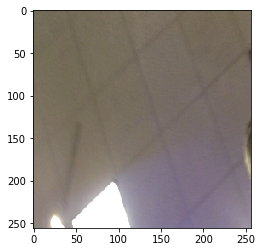

NameError: name 'y_edge' is not defined

In [11]:
plt.imshow(data[197])
plt.show()
plt.imshow(y_edge[97])
plt.show()

In [298]:
import scipy
import cv2
import matplotlib.pyplot as plt
for width in [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]:
    #y_edge = np.logical_or(y[:, 2:, 1:-1] != y[:, :-2, 1:-1], 0)
    y_edge = np.array([scipy.ndimage.binary_dilation(y_e, iterations=width) for y_e in classes])[:, ::2, ::2] * 1.0
    for _ in range(700):
        #augment by rotation
        print("rotation")
        angle = np.random.randint(360)
        
        batchx = scipy.ndimage.interpolation.rotate(data, angle, (1, 2), False, mode="constant", cval=0)
        batchy = scipy.ndimage.interpolation.rotate(y_edge, angle, (1, 2), False, mode="constant", cval=-1)
        
        batchx = np.clip(batchx, 0, 1)

        
      
        #batchx = np.concatenate([batchx, -batchx]) / 255.

        print("scaling")
        maxcrop = 90
        shape = batchx[0].shape
        
        final_x = []
        final_y = []
        for i in range(len(batchx)):
            
            while True:
                
                x1 = np.random.randint(0, maxcrop)
                x2 = np.random.randint(256 - maxcrop, 256)

                y1 = np.random.randint(0, maxcrop)
                y2 = np.random.randint(256 - maxcrop, 256)
                
                

                y_test = batchy[i, x1:x2, y1:y2]

                if not(np.any(y_test == -1)):
                    break
            
            final_x.append(cv2.resize(batchx[i, x1:x2:2, y1:y2:2], (128, 128)))
            final_y.append(cv2.resize(batchy[i, x1:x2:2, y1:y2:2], (128, 128)))
            
        print("duplicating")
        
        
        batchx = np.array(final_x)
        batchy = np.array(final_y)
        
        batchy = np.expand_dims(batchy, -1)
        batchy = np.concatenate([batchy, 1-batchy], -1)
        
        batchx = np.concatenate([batchx, np.flip(batchx, 2)])
        batchy = np.concatenate([batchy, np.flip(batchy, 2)])
        
        batchx = np.concatenate([batchx, np.flip(batchx, 1)])
        batchy = np.concatenate([batchy, np.flip(batchy, 1)])
        
        batchx = np.concatenate([batchx, np.transpose(batchx, (0, 2, 1, 3))])
        batchy = np.concatenate([batchy, np.transpose(batchy, (0, 2, 1, 3))])
        
        #offset = np.random.random((len(batchx), 1, 1, 1)) / 4 - .125
        #scale = np.random.random((len(batchx), 1, 1, 1)) / 2 + .75
 
        #batchx = scale * batchx + offset
    
        scale = np.random.uniform(-1.4, 1.4, (len(batchx), 1, 1, 1))


        batchx = (batchx + 0.0) ** ( 2.5 **scale)
            
        
    
        
        for i in range(2):
            l = models[i].fit(batchx, batchy, validation_data=(testdata_ready, testclasses_ready), batch_size=len(batchx) // 12)
            loss[i].append(l)
        

rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 5s - loss: 0.1951 - val_loss: 0.1382
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 4s - loss: 0.2599 - val_loss: 0.1345
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.1254 - val_loss: 0.1368
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.1420 - val_loss: 0.1473
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.1151 - val_loss: 0.1389
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.1204 - val_loss: 0.1337
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1


1936/1936 [==============================] - 3s - loss: 0.0998 - val_loss: 0.1231
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0893 - val_loss: 0.0991
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.1004 - val_loss: 0.1417
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0909 - val_loss: 0.0979
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.1084 - val_loss: 0.1255
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0878 - val_loss: 0.1045
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.1075 - val_loss: 0.1249
rot

1936/1936 [==============================] - 3s - loss: 0.0882 - val_loss: 0.1007
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0765 - val_loss: 0.0843
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0888 - val_loss: 0.1046
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0768 - val_loss: 0.0888
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0895 - val_loss: 0.0997
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0755 - val_loss: 0.0891
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0856 - val_loss: 0.1051
rot

1936/1936 [==============================] - 3s - loss: 0.0786 - val_loss: 0.0925
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0689 - val_loss: 0.0815
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0768 - val_loss: 0.0915
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0672 - val_loss: 0.0794
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0769 - val_loss: 0.0893
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0653 - val_loss: 0.0773
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0758 - val_loss: 0.0905
rot

1936/1936 [==============================] - 3s - loss: 0.0703 - val_loss: 0.0880
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0627 - val_loss: 0.0741
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0715 - val_loss: 0.0824
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0616 - val_loss: 0.0737
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0710 - val_loss: 0.0847
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0619 - val_loss: 0.0747
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0705 - val_loss: 0.0820
rot

1936/1936 [==============================] - 3s - loss: 0.0650 - val_loss: 0.0782
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0581 - val_loss: 0.0697
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0668 - val_loss: 0.0764
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0566 - val_loss: 0.0703
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0633 - val_loss: 0.0784
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0559 - val_loss: 0.0693
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0642 - val_loss: 0.0796
rot

1936/1936 [==============================] - 3s - loss: 0.0665 - val_loss: 0.0784
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0532 - val_loss: 0.0682
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0658 - val_loss: 0.0766
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0549 - val_loss: 0.0659
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0631 - val_loss: 0.0789
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0562 - val_loss: 0.0666
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0638 - val_loss: 0.0785
rot

1936/1936 [==============================] - 3s - loss: 0.0546 - val_loss: 0.0679
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0491 - val_loss: 0.0648
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0545 - val_loss: 0.0692
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0518 - val_loss: 0.0630
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0548 - val_loss: 0.0693
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0490 - val_loss: 0.0621
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0556 - val_loss: 0.0741
rot

1936/1936 [==============================] - 3s - loss: 0.0511 - val_loss: 0.0645
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0491 - val_loss: 0.0610
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0518 - val_loss: 0.0657
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0469 - val_loss: 0.0722
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0499 - val_loss: 0.0725
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0687 - val_loss: 0.0704
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0571 - val_loss: 0.0682
rot

1936/1936 [==============================] - 3s - loss: 0.0501 - val_loss: 0.0630
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0465 - val_loss: 0.0664
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0487 - val_loss: 0.0630
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0508 - val_loss: 0.0603
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0527 - val_loss: 0.0670
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0474 - val_loss: 0.0589
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0510 - val_loss: 0.0653
rot

1936/1936 [==============================] - 3s - loss: 0.0491 - val_loss: 0.0620
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0441 - val_loss: 0.0591
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0498 - val_loss: 0.0637
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0465 - val_loss: 0.0572
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0496 - val_loss: 0.0629
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0450 - val_loss: 0.0556
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0493 - val_loss: 0.0616
rot

1936/1936 [==============================] - 3s - loss: 0.0462 - val_loss: 0.0583
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0436 - val_loss: 0.0572
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0477 - val_loss: 0.0603
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0420 - val_loss: 0.0601
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0486 - val_loss: 0.0615
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0448 - val_loss: 0.0610
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0483 - val_loss: 0.0615
rot

1936/1936 [==============================] - 3s - loss: 0.0448 - val_loss: 0.0582
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0411 - val_loss: 0.0552
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0447 - val_loss: 0.0630
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0433 - val_loss: 0.0559
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0470 - val_loss: 0.0590
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0414 - val_loss: 0.0534
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0459 - val_loss: 0.0741
rot

1936/1936 [==============================] - 3s - loss: 0.0473 - val_loss: 0.0645
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0412 - val_loss: 0.0582
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0510 - val_loss: 0.0639
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0410 - val_loss: 0.0562
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0550 - val_loss: 0.0767
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0420 - val_loss: 0.0570
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0551 - val_loss: 0.0641
rot

1936/1936 [==============================] - 3s - loss: 0.0445 - val_loss: 0.0615
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0416 - val_loss: 0.0614
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0435 - val_loss: 0.0596
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0407 - val_loss: 0.0567
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0440 - val_loss: 0.0633
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0444 - val_loss: 0.0583
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0482 - val_loss: 0.0672
rot

1936/1936 [==============================] - 3s - loss: 0.0418 - val_loss: 0.0612
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0371 - val_loss: 0.0557
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0412 - val_loss: 0.0582
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0383 - val_loss: 0.0559
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0421 - val_loss: 0.0625
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0390 - val_loss: 0.0577
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0423 - val_loss: 0.0572
rot

1936/1936 [==============================] - 3s - loss: 0.0416 - val_loss: 0.0592
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0419 - val_loss: 0.0541
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0455 - val_loss: 0.0567
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0430 - val_loss: 0.0558
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0453 - val_loss: 0.0572
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0401 - val_loss: 0.0621
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0437 - val_loss: 0.0561
rot

1936/1936 [==============================] - 3s - loss: 0.0463 - val_loss: 0.0580
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0390 - val_loss: 0.0559
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0444 - val_loss: 0.0547
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0378 - val_loss: 0.0552
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0452 - val_loss: 0.0598
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0382 - val_loss: 0.0565
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0421 - val_loss: 0.0573
rot

1936/1936 [==============================] - 3s - loss: 0.0437 - val_loss: 0.0532
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0573
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0404 - val_loss: 0.0545
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0545
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0393 - val_loss: 0.0636
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0378 - val_loss: 0.0772
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0444 - val_loss: 0.0579
rot

1936/1936 [==============================] - 3s - loss: 0.0450 - val_loss: 0.0566
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0378 - val_loss: 0.0534
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0408 - val_loss: 0.0557
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0370 - val_loss: 0.0545
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0403 - val_loss: 0.0551
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0382 - val_loss: 0.0517
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0397 - val_loss: 0.0544
rot

1936/1936 [==============================] - 3s - loss: 0.0399 - val_loss: 0.0541
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0368 - val_loss: 0.0526
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0396 - val_loss: 0.0569
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0358 - val_loss: 0.0517
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0386 - val_loss: 0.0566
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0430 - val_loss: 0.0612
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0385 - val_loss: 0.0559
rot

1936/1936 [==============================] - 3s - loss: 0.0405 - val_loss: 0.0550
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0400 - val_loss: 0.0521
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0386 - val_loss: 0.0546
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0372 - val_loss: 0.0530
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0388 - val_loss: 0.0557
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0377 - val_loss: 0.0523
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0414 - val_loss: 0.0539
rot

1936/1936 [==============================] - 3s - loss: 0.0376 - val_loss: 0.0563
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0376 - val_loss: 0.0513
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0443 - val_loss: 0.0516
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0353 - val_loss: 0.0510
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0391 - val_loss: 0.0515
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0362 - val_loss: 0.0523
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0384 - val_loss: 0.0543
rot

1936/1936 [==============================] - 3s - loss: 0.0370 - val_loss: 0.0526
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0386 - val_loss: 0.0579
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0399 - val_loss: 0.0533
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0412 - val_loss: 0.0534
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0387 - val_loss: 0.0538
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0380 - val_loss: 0.0522
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0375 - val_loss: 0.0539
rot

1936/1936 [==============================] - 3s - loss: 0.0353 - val_loss: 0.0545
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0362 - val_loss: 0.0497
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0361 - val_loss: 0.0530
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0347 - val_loss: 0.0527
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0356 - val_loss: 0.0546
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0339 - val_loss: 0.0509
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0354 - val_loss: 0.0575
rot

1936/1936 [==============================] - 3s - loss: 0.0383 - val_loss: 0.0527
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0371 - val_loss: 0.0540
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0375 - val_loss: 0.0505
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0394 - val_loss: 0.0558
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0380 - val_loss: 0.0512
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0407 - val_loss: 0.0531
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0356 - val_loss: 0.0518
rot

1936/1936 [==============================] - 3s - loss: 0.0346 - val_loss: 0.0520
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0364 - val_loss: 0.0505
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0368 - val_loss: 0.0537
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0359 - val_loss: 0.0511
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0520 - val_loss: 0.0603
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0348 - val_loss: 0.0507
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0473 - val_loss: 0.0555
rot

1936/1936 [==============================] - 3s - loss: 0.0420 - val_loss: 0.0532
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0379 - val_loss: 0.0501
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0511 - val_loss: 0.0588
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0354 - val_loss: 0.0542
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0429 - val_loss: 0.0505
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0347 - val_loss: 0.0481
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0397 - val_loss: 0.0499
rot

1936/1936 [==============================] - 3s - loss: 0.0382 - val_loss: 0.0497
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0496
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0386 - val_loss: 0.0494
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0360 - val_loss: 0.0492
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0389 - val_loss: 0.0514
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0367 - val_loss: 0.0502
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0383 - val_loss: 0.0538
rot

1936/1936 [==============================] - 3s - loss: 0.0373 - val_loss: 0.0507
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0344 - val_loss: 0.0560
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0524
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0341 - val_loss: 0.0511
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0358 - val_loss: 0.0544
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0347 - val_loss: 0.0508
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0513
rot

1936/1936 [==============================] - 3s - loss: 0.0346 - val_loss: 0.0511
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0349 - val_loss: 0.0498
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0367 - val_loss: 0.0514
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0342 - val_loss: 0.0516
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0344 - val_loss: 0.0514
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0332 - val_loss: 0.0485
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0348 - val_loss: 0.0503
rot

1936/1936 [==============================] - 3s - loss: 0.0353 - val_loss: 0.0524
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0504
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0352 - val_loss: 0.0520
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0335 - val_loss: 0.0504
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0359 - val_loss: 0.0524
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0492
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0355 - val_loss: 0.0510
rot

1936/1936 [==============================] - 3s - loss: 0.0353 - val_loss: 0.0497
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0323 - val_loss: 0.0489
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0487
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0488
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0346 - val_loss: 0.0513
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0375 - val_loss: 0.0471
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0404 - val_loss: 0.0516
rot

1936/1936 [==============================] - 3s - loss: 0.0405 - val_loss: 0.0504
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0324 - val_loss: 0.0496
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0393 - val_loss: 0.0510
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0367 - val_loss: 0.0503
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0421 - val_loss: 0.0523
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0332 - val_loss: 0.0489
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0399 - val_loss: 0.0551
rot

1936/1936 [==============================] - 3s - loss: 0.0353 - val_loss: 0.0495
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0470
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0341 - val_loss: 0.0489
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0488
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0358 - val_loss: 0.0510
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0478
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0383 - val_loss: 0.0499
rot

1936/1936 [==============================] - 3s - loss: 0.0349 - val_loss: 0.0472
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0468
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0342 - val_loss: 0.0465
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0465
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0339 - val_loss: 0.0537
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0465
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0356 - val_loss: 0.0482
rot

1936/1936 [==============================] - 3s - loss: 0.0338 - val_loss: 0.0501
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0318 - val_loss: 0.0463
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0334 - val_loss: 0.0504
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0314 - val_loss: 0.0488
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0328 - val_loss: 0.0488
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0472
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0328 - val_loss: 0.0488
rot

1936/1936 [==============================] - 3s - loss: 0.0324 - val_loss: 0.0471
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0330 - val_loss: 0.0458
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0347 - val_loss: 0.0473
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0313 - val_loss: 0.0461
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0342 - val_loss: 0.0466
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0323 - val_loss: 0.0469
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0338 - val_loss: 0.0531
rot

1936/1936 [==============================] - 3s - loss: 0.0351 - val_loss: 0.0467
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0463
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0338 - val_loss: 0.0470
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0485
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0337 - val_loss: 0.0474
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0344 - val_loss: 0.0498
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0334 - val_loss: 0.0472
rot

1936/1936 [==============================] - 3s - loss: 0.0330 - val_loss: 0.0483
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0334 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0354 - val_loss: 0.0471
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0340 - val_loss: 0.0471
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0350 - val_loss: 0.0475
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0313 - val_loss: 0.0503
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0340 - val_loss: 0.0467
rot

1936/1936 [==============================] - 3s - loss: 0.0324 - val_loss: 0.0486
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0482
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0478
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0335 - val_loss: 0.0488
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0331 - val_loss: 0.0492
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0495
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0314 - val_loss: 0.0481
rot

1936/1936 [==============================] - 3s - loss: 0.0359 - val_loss: 0.0498
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0318 - val_loss: 0.0468
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0368 - val_loss: 0.0474
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0315 - val_loss: 0.0469
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0353 - val_loss: 0.0494
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0322 - val_loss: 0.0484
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0345 - val_loss: 0.0488
rot

1936/1936 [==============================] - 3s - loss: 0.0341 - val_loss: 0.0497
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0474
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0314 - val_loss: 0.0512
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0475
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0503
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0489
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0498
rot

1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0475
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0487
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0497
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0349 - val_loss: 0.0467
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0365 - val_loss: 0.0485
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0467
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0337 - val_loss: 0.0509
rot

1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0458
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0301 - val_loss: 0.0455
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0485
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0464
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0318 - val_loss: 0.0474
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0291 - val_loss: 0.0470
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0323 - val_loss: 0.0495
rot

1936/1936 [==============================] - 3s - loss: 0.0327 - val_loss: 0.0462
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0306 - val_loss: 0.0466
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0452
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0473
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0471
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0348 - val_loss: 0.0464
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0352 - val_loss: 0.0462
rot

1936/1936 [==============================] - 3s - loss: 0.0340 - val_loss: 0.0485
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0324 - val_loss: 0.0456
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0322 - val_loss: 0.0482
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0467
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0477
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0302 - val_loss: 0.0483
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0309 - val_loss: 0.0486
rot

1936/1936 [==============================] - 3s - loss: 0.0323 - val_loss: 0.0481
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0310 - val_loss: 0.0469
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0331 - val_loss: 0.0488
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0333 - val_loss: 0.0475
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0356 - val_loss: 0.0461
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0458
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0325 - val_loss: 0.0478
rot

1936/1936 [==============================] - 3s - loss: 0.0324 - val_loss: 0.0472
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0288 - val_loss: 0.0473
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0317 - val_loss: 0.0487
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0472
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0325 - val_loss: 0.0497
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0475
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0336 - val_loss: 0.0484
rot

1936/1936 [==============================] - 3s - loss: 0.0322 - val_loss: 0.0476
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0510
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0302 - val_loss: 0.0475
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0342 - val_loss: 0.0502
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0332 - val_loss: 0.0494
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0469
rot

1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0485
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0317 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0333 - val_loss: 0.0462
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0437
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0323 - val_loss: 0.0476
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0472
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0314 - val_loss: 0.0472
rot

1936/1936 [==============================] - 3s - loss: 0.0303 - val_loss: 0.0498
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0277 - val_loss: 0.0473
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0479
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0471
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0493
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0490
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0304 - val_loss: 0.0515
rot

1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0468
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0317 - val_loss: 0.0454
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0488
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0337 - val_loss: 0.0484
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0458
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0350 - val_loss: 0.0472
rot

1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0478
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0303 - val_loss: 0.0444
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0488
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0468
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0295 - val_loss: 0.0436
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0303 - val_loss: 0.0478
rot

1936/1936 [==============================] - 3s - loss: 0.0303 - val_loss: 0.0491
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0443
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0337 - val_loss: 0.0500
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0281 - val_loss: 0.0451
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0306 - val_loss: 0.0476
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0456
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0485
rot

1936/1936 [==============================] - 3s - loss: 0.0306 - val_loss: 0.0480
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0288 - val_loss: 0.0469
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0497
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0352 - val_loss: 0.0508
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0274 - val_loss: 0.0459
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0332 - val_loss: 0.0478
rot

1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0489
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0458
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0359 - val_loss: 0.0497
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0284 - val_loss: 0.0460
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0320 - val_loss: 0.0462
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0313 - val_loss: 0.0467
rot

1936/1936 [==============================] - 3s - loss: 0.0303 - val_loss: 0.0482
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0468
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0314 - val_loss: 0.0494
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0276 - val_loss: 0.0477
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0306 - val_loss: 0.0473
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0265 - val_loss: 0.0465
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0481
rot

1936/1936 [==============================] - 3s - loss: 0.0315 - val_loss: 0.0483
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0476
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0330 - val_loss: 0.0472
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0466
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0465
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0472
rot

1936/1936 [==============================] - 3s - loss: 0.0278 - val_loss: 0.0483
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0315 - val_loss: 0.0463
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0327 - val_loss: 0.0477
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0462
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0470
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0331 - val_loss: 0.0462
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0353 - val_loss: 0.0476
rot

1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0470
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0476
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0437
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0476
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0281 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0472
rot

1936/1936 [==============================] - 3s - loss: 0.0313 - val_loss: 0.0474
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0274 - val_loss: 0.0456
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0485
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0451
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0462
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0474
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0460
rot

1936/1936 [==============================] - 3s - loss: 0.0378 - val_loss: 0.0466
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0446
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0361 - val_loss: 0.0470
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0320 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0383 - val_loss: 0.0450
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0299 - val_loss: 0.0451
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0327 - val_loss: 0.0447
rot

1936/1936 [==============================] - 3s - loss: 0.0330 - val_loss: 0.0461
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0299 - val_loss: 0.0468
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0462
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0316 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0456
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0438
rot

1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0456
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0310 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0464
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0470
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0302 - val_loss: 0.0467
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0317 - val_loss: 0.0443
rot

1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0481
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0461
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0468
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0278 - val_loss: 0.0466
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0480
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0270 - val_loss: 0.0445
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0462
rot

1936/1936 [==============================] - 3s - loss: 0.0341 - val_loss: 0.0450
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0478
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0288 - val_loss: 0.0447
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0281 - val_loss: 0.0450
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0281 - val_loss: 0.0477
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0322 - val_loss: 0.0449
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0288 - val_loss: 0.0465
rot

1936/1936 [==============================] - 3s - loss: 0.0310 - val_loss: 0.0466
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0461
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0473
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0284 - val_loss: 0.0473
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0476
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0289 - val_loss: 0.0465
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0474
rot

1936/1936 [==============================] - 3s - loss: 0.0310 - val_loss: 0.0467
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0299 - val_loss: 0.0481
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0323 - val_loss: 0.0486
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0323 - val_loss: 0.0484
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0406 - val_loss: 0.0520
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0484
rot

1936/1936 [==============================] - 3s - loss: 0.0315 - val_loss: 0.0457
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0301 - val_loss: 0.0444
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0314 - val_loss: 0.0441
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0304 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0438
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0455
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0313 - val_loss: 0.0455
rot

1936/1936 [==============================] - 3s - loss: 0.0315 - val_loss: 0.0432
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0431
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0442
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0428
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0302 - val_loss: 0.0440
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0420
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0465
rot

1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0446
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0278 - val_loss: 0.0441
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0468
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0434
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0291 - val_loss: 0.0439
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0451
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0478
rot

1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0460
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0435
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0458
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0282 - val_loss: 0.0423
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0447
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0266 - val_loss: 0.0432
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0282 - val_loss: 0.0466
rot

1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0467
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0268 - val_loss: 0.0459
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0448
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0258 - val_loss: 0.0462
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0458
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0270 - val_loss: 0.0460
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0447
rot

1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0453
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0439
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0459
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0440
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0299 - val_loss: 0.0484
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0268 - val_loss: 0.0438
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0360 - val_loss: 0.0468
rot

1936/1936 [==============================] - 3s - loss: 0.0291 - val_loss: 0.0441
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0259 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0461
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0461
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0454
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0467
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0479
rot

1936/1936 [==============================] - 3s - loss: 0.0311 - val_loss: 0.0473
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0480
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0434
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0471
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0265 - val_loss: 0.0430
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0466
rot

1936/1936 [==============================] - 3s - loss: 0.0282 - val_loss: 0.0461
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0479
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0275 - val_loss: 0.0469
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0473
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0275 - val_loss: 0.0466
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0314 - val_loss: 0.0472
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0473
rot

1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0452
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0278 - val_loss: 0.0459
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0473
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0457
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0318 - val_loss: 0.0471
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0271 - val_loss: 0.0465
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0450
rot

1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0464
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0449
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0276 - val_loss: 0.0462
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0265 - val_loss: 0.0446
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0265 - val_loss: 0.0458
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0277 - val_loss: 0.0440
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0462
rot

1936/1936 [==============================] - 3s - loss: 0.0275 - val_loss: 0.0432
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0446
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0267 - val_loss: 0.0441
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0445
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0452
rot

1936/1936 [==============================] - 3s - loss: 0.0268 - val_loss: 0.0442
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0274 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0448
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0432
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0270 - val_loss: 0.0465
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0252 - val_loss: 0.0451
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0270 - val_loss: 0.0449
rot

1936/1936 [==============================] - 3s - loss: 0.0275 - val_loss: 0.0463
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0251 - val_loss: 0.0450
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0267 - val_loss: 0.0452
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0444
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0442
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0289 - val_loss: 0.0450
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0442
rot

1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0451
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0439
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0449
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0262 - val_loss: 0.0431
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0441
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0262 - val_loss: 0.0431
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0271 - val_loss: 0.0439
rot

1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0457
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0266 - val_loss: 0.0454
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0277 - val_loss: 0.0445
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0437
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0284 - val_loss: 0.0464
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0256 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0457
rot

1936/1936 [==============================] - 3s - loss: 0.0303 - val_loss: 0.0471
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0275 - val_loss: 0.0441
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0274 - val_loss: 0.0456
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0430
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0438
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0262 - val_loss: 0.0444
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0438
rot

1936/1936 [==============================] - 3s - loss: 0.0581 - val_loss: 0.0631
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0265 - val_loss: 0.0443
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0523 - val_loss: 0.0628
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0258 - val_loss: 0.0436
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0536 - val_loss: 0.0591
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0274 - val_loss: 0.0461
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0471 - val_loss: 0.0537
rot

1936/1936 [==============================] - 3s - loss: 0.0345 - val_loss: 0.0462
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0261 - val_loss: 0.0452
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0321 - val_loss: 0.0505
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0276 - val_loss: 0.0441
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0410 - val_loss: 0.0466
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0271 - val_loss: 0.0430
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0356 - val_loss: 0.0447
rot

1936/1936 [==============================] - 3s - loss: 0.0310 - val_loss: 0.0445
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0258 - val_loss: 0.0436
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0482
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0248 - val_loss: 0.0438
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0363 - val_loss: 0.0469
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0259 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0330 - val_loss: 0.0468
rot

1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0449
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0299 - val_loss: 0.0443
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0268 - val_loss: 0.0428
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0299 - val_loss: 0.0436
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0254 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0289 - val_loss: 0.0437
rot

1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0437
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0460
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0443
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0256 - val_loss: 0.0457
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0445
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0249 - val_loss: 0.0452
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0271 - val_loss: 0.0434
rot

1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0439
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0246 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0445
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0450
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0322 - val_loss: 0.0447
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0289 - val_loss: 0.0461
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0309 - val_loss: 0.0437
rot

1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0440
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0256 - val_loss: 0.0467
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0278 - val_loss: 0.0457
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0478
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0281 - val_loss: 0.0442
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0462
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0443
rot

1936/1936 [==============================] - 3s - loss: 0.0291 - val_loss: 0.0447
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0244 - val_loss: 0.0446
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0504
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0259 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0477 - val_loss: 0.0613
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0310 - val_loss: 0.0434
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0496 - val_loss: 0.0580
rot

1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0429
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0256 - val_loss: 0.0427
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0438
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0238 - val_loss: 0.0450
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0416
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0250 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0443
rot

1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0417
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0264 - val_loss: 0.0422
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0282 - val_loss: 0.0417
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0262 - val_loss: 0.0424
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0414
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0270 - val_loss: 0.0419
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0419
rot

1936/1936 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0438
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0247 - val_loss: 0.0447
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0264 - val_loss: 0.0447
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0246 - val_loss: 0.0456
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0264 - val_loss: 0.0451
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0466
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0448
rot

1936/1936 [==============================] - 3s - loss: 0.0330 - val_loss: 0.0431
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0429
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0295 - val_loss: 0.0442
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0254 - val_loss: 0.0429
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0427
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0267 - val_loss: 0.0432
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0427
rot

1936/1936 [==============================] - 3s - loss: 0.0276 - val_loss: 0.0416
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0415
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0258 - val_loss: 0.0526
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0267 - val_loss: 0.0415
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0515 - val_loss: 0.0542
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0301 - val_loss: 0.0413
rot

1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0441
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0426
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0295 - val_loss: 0.0424
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0298 - val_loss: 0.0435
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0435
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0264 - val_loss: 0.0440
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0282 - val_loss: 0.0432
rot

1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0451
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0436
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0347 - val_loss: 0.0452
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0295 - val_loss: 0.0428
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0317 - val_loss: 0.0448
rot

1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0447
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0257 - val_loss: 0.0472
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0288 - val_loss: 0.0475
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0458
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0318 - val_loss: 0.0468
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0284 - val_loss: 0.0434
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0302 - val_loss: 0.0446
rot

1936/1936 [==============================] - 3s - loss: 0.0267 - val_loss: 0.0433
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0257 - val_loss: 0.0452
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0453
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0259 - val_loss: 0.0466
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0448
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0444
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0443
rot

1936/1936 [==============================] - 3s - loss: 0.0257 - val_loss: 0.0436
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0430
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0286 - val_loss: 0.0423
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0240 - val_loss: 0.0432
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0422
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0253 - val_loss: 0.0448
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0266 - val_loss: 0.0433
rot

1936/1936 [==============================] - 3s - loss: 0.0302 - val_loss: 0.0438
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0277 - val_loss: 0.0452
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0591
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0445
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0727 - val_loss: 0.0965
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0261 - val_loss: 0.0440
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0857 - val_loss: 0.0905
rot

1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0436
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0441
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0312 - val_loss: 0.0547
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0277 - val_loss: 0.0439
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0504 - val_loss: 0.0513
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0268 - val_loss: 0.0450
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0406 - val_loss: 0.0423
rot

1936/1936 [==============================] - 3s - loss: 0.0896 - val_loss: 0.1059
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0365 - val_loss: 0.0513
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0871 - val_loss: 0.1069
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0357 - val_loss: 0.0520
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0859 - val_loss: 0.1043
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0377 - val_loss: 0.0495
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0804 - val_loss: 0.0918
rot

1936/1936 [==============================] - 3s - loss: 0.0573 - val_loss: 0.0888
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0440
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0581 - val_loss: 0.0650
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0302 - val_loss: 0.0449
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0561 - val_loss: 0.0640
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0324 - val_loss: 0.0452
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0559 - val_loss: 0.0604
rot

1936/1936 [==============================] - 3s - loss: 0.0425 - val_loss: 0.0509
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0295 - val_loss: 0.0437
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0419 - val_loss: 0.0495
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0281 - val_loss: 0.0428
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0398 - val_loss: 0.0489
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0424
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0393 - val_loss: 0.0505
rot

1936/1936 [==============================] - 3s - loss: 0.0352 - val_loss: 0.0461
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0265 - val_loss: 0.0423
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0343 - val_loss: 0.0461
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0305 - val_loss: 0.0441
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0380 - val_loss: 0.0465
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0274 - val_loss: 0.0430
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0354 - val_loss: 0.0461
rot

1936/1936 [==============================] - 3s - loss: 0.0349 - val_loss: 0.0449
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0270 - val_loss: 0.0424
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0329 - val_loss: 0.0445
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0260 - val_loss: 0.0434
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0317 - val_loss: 0.0452
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0456
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0338 - val_loss: 0.0446
rot

1936/1936 [==============================] - 3s - loss: 0.0542 - val_loss: 0.0589
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0257 - val_loss: 0.0435
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0482 - val_loss: 0.0529
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0292 - val_loss: 0.0435
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0488 - val_loss: 0.0519
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0419
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0468 - val_loss: 0.0508
rot

1936/1936 [==============================] - 3s - loss: 0.0336 - val_loss: 0.0437
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0242 - val_loss: 0.0426
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0320 - val_loss: 0.0441
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0264 - val_loss: 0.0428
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0344 - val_loss: 0.0438
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0256 - val_loss: 0.0433
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0336 - val_loss: 0.0446
rot

1936/1936 [==============================] - 3s - loss: 0.0372 - val_loss: 0.0460
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0455
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0326 - val_loss: 0.0433
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0271 - val_loss: 0.0455
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0313 - val_loss: 0.0436
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0293 - val_loss: 0.0453
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0331 - val_loss: 0.0432
rot

1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0450
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0260 - val_loss: 0.0464
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0287 - val_loss: 0.0630
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0275 - val_loss: 0.0446
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0639 - val_loss: 0.0667
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0250 - val_loss: 0.0435
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0495 - val_loss: 0.0547
rot

1936/1936 [==============================] - 3s - loss: 0.0300 - val_loss: 0.0443
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0260 - val_loss: 0.0435
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0306 - val_loss: 0.0433
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0425
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0308 - val_loss: 0.0437
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0273 - val_loss: 0.0434
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0327 - val_loss: 0.0439
rot

1936/1936 [==============================] - 3s - loss: 0.0307 - val_loss: 0.0428
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0242 - val_loss: 0.0438
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0510
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0238 - val_loss: 0.0446
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0568 - val_loss: 0.0644
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0258 - val_loss: 0.0428
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0515 - val_loss: 0.0581
rot

1936/1936 [==============================] - 3s - loss: 0.0282 - val_loss: 0.0416
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0426
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0303 - val_loss: 0.0433
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0272 - val_loss: 0.0442
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0426
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0267 - val_loss: 0.0440
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0296 - val_loss: 0.0441
rot

1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0431
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0352 - val_loss: 0.0529
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0278 - val_loss: 0.0447
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0333 - val_loss: 0.0542
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0282 - val_loss: 0.0452
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0335 - val_loss: 0.0543
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0275 - val_loss: 0.0444
rot

1936/1936 [==============================] - 3s - loss: 0.0284 - val_loss: 0.0434
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0454
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0297 - val_loss: 0.0425
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0290 - val_loss: 0.0444
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0436
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0304 - val_loss: 0.0451
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0289 - val_loss: 0.0436
rot

1936/1936 [==============================] - 3s - loss: 0.0283 - val_loss: 0.0448
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0257 - val_loss: 0.0450
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0271 - val_loss: 0.0443
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0454
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0269 - val_loss: 0.0440
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0336 - val_loss: 0.0469
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0279 - val_loss: 0.0429
rot

1936/1936 [==============================] - 3s - loss: 0.0260 - val_loss: 0.0432
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0319 - val_loss: 0.0463
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0289 - val_loss: 0.0434
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0301 - val_loss: 0.0452
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0295 - val_loss: 0.0428
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0281 - val_loss: 0.0443
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0291 - val_loss: 0.0425
rot

1936/1936 [==============================] - 3s - loss: 0.0265 - val_loss: 0.0446
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0259 - val_loss: 0.0442
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0277 - val_loss: 0.0438
rotation
scaling
duplicating
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0274 - val_loss: 0.0451
Train on 1936 samples, validate on 51 samples
Epoch 1/1
1936/1936 [==============================] - 3s - loss: 0.0285 - val_loss: 0.0444
rotation


KeyboardInterrupt: 

In [296]:
np.max(batchx)


1.0

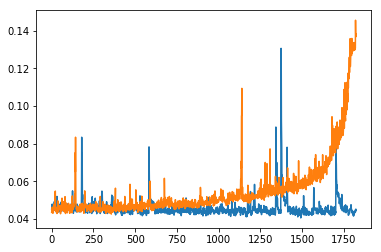

In [386]:
for i in range(1):
    plt.plot([l.history["val_loss"] for l in loss[i]][1500:])
    plt.plot([l.history["val_loss"] for l in loss[i]][-1500::-1])
    #plt.plot([l.history["loss"] for l in loss[i]][:])
#plt.plot([0], [0])
plt.show()

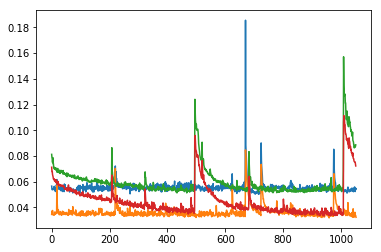

In [33]:
for i in range(2):
    plt.plot([l.history["val_loss"] for l in loss[i]][:])
    plt.plot([l.history["loss"] for l in loss[i]][:])
plt.show()

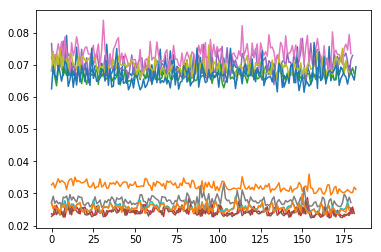

In [402]:
for i in range(6):
    plt.plot([l.history["val_loss"] for l in loss[i]][2500:])
    plt.plot([l.history["loss"] for l in loss[i]][2500:])
plt.show()

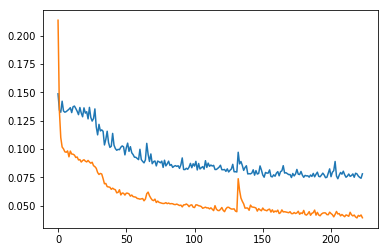

In [370]:
plt.plot([l.history["val_loss"] for l in loss])
plt.plot([l.history["loss"] for l in loss])
plt.show()

In [219]:
rot_mat = cv2.getRotationMatrix2D((64, 64), 45, 1.0)
result = cv2.warpAffine(data, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

NameError: name 'image' is not defined

125
(484, 128, 128, 3) (484, 128, 128, 2)
1 <keras.callbacks.History object at 0x000002356378AEF0>


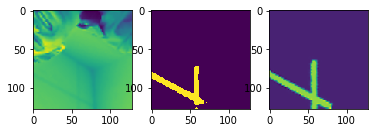

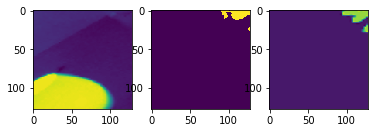

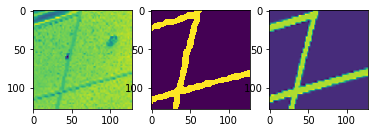

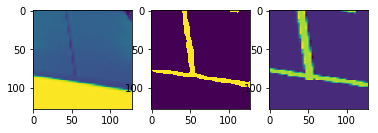

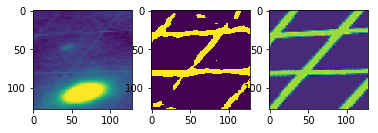

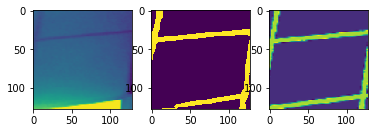

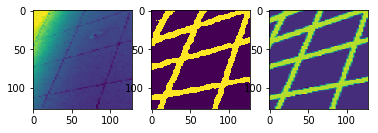

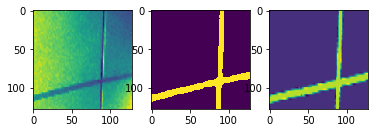

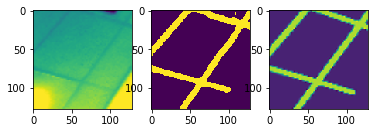

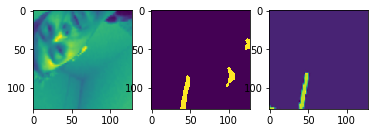

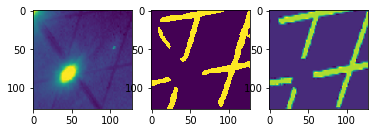

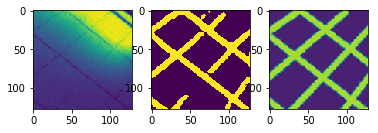

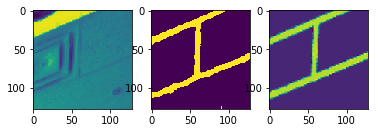

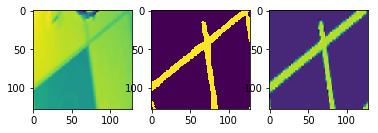

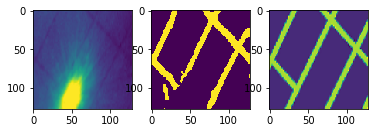

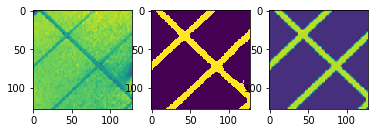

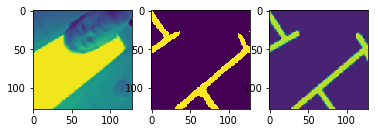

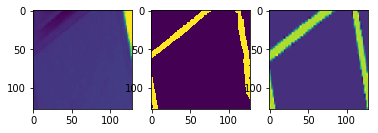

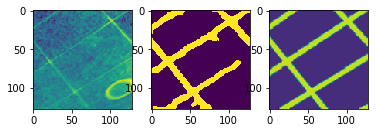

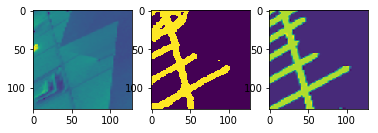

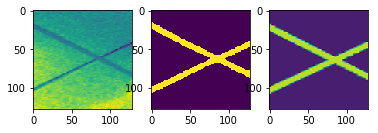

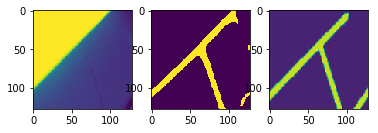

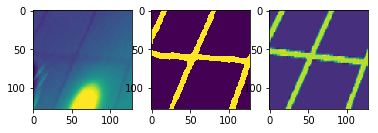

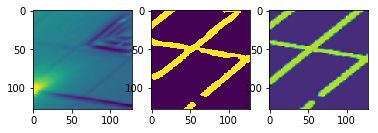

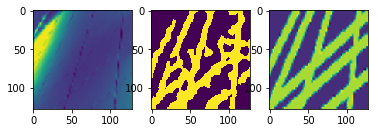

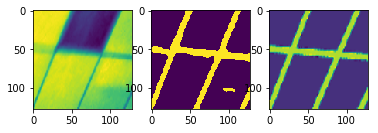

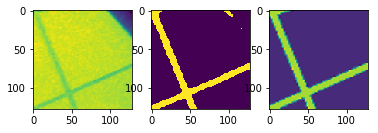

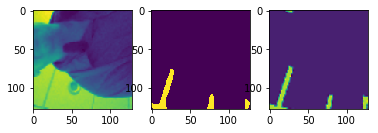

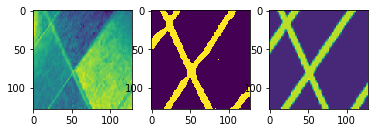

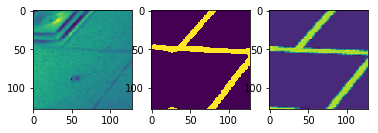

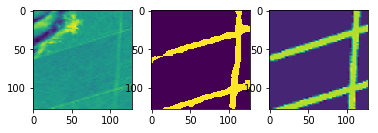

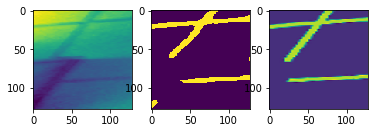

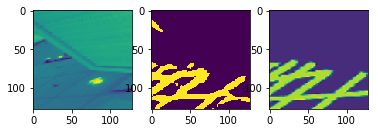

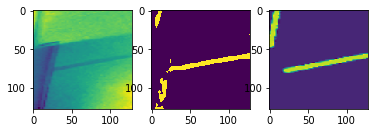

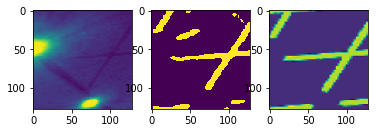

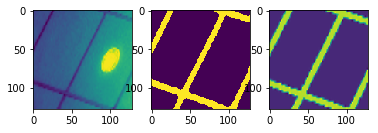

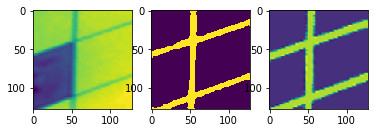

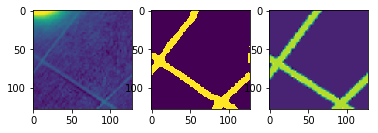

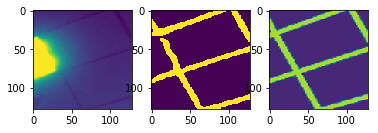

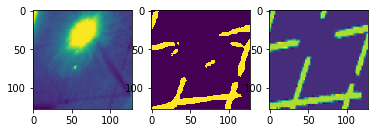

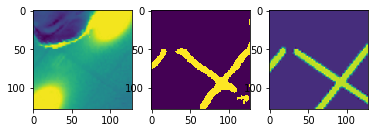

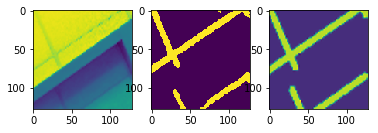

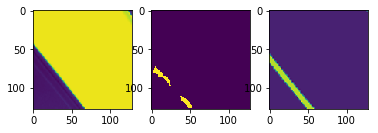

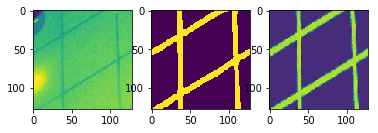

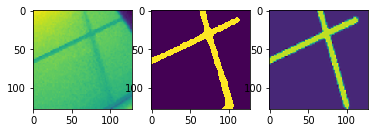

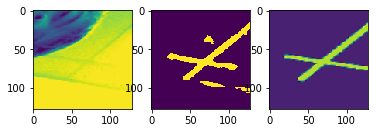

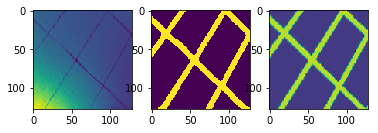

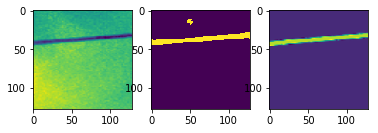

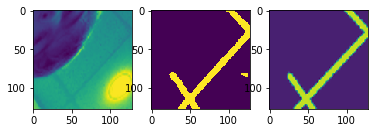

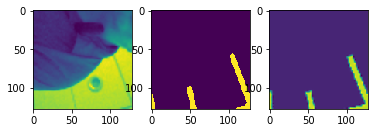

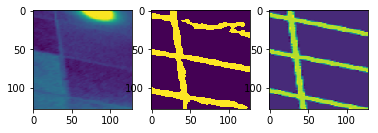

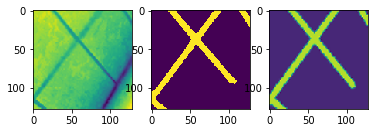

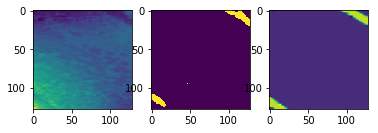

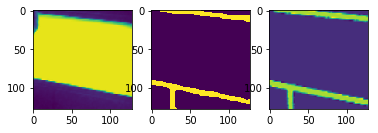

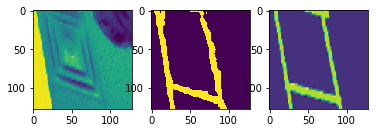

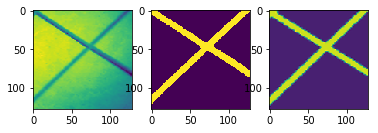

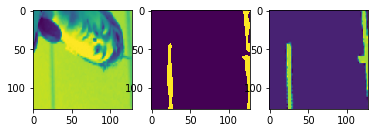

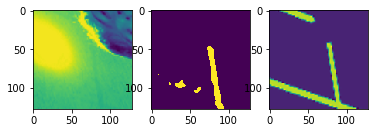

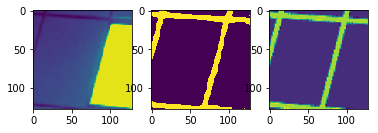

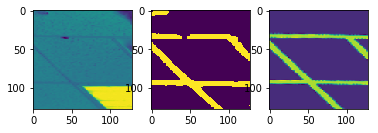

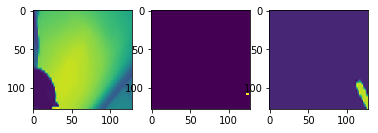

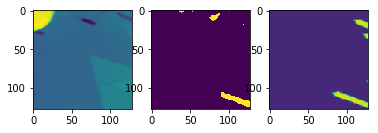

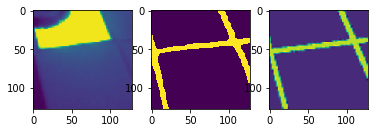

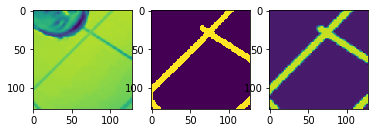

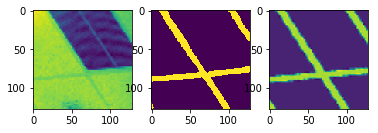

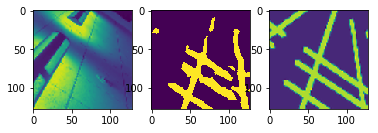

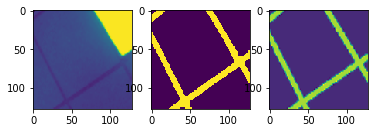

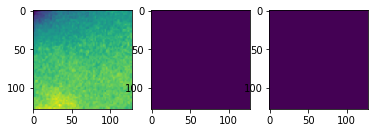

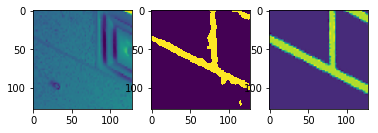

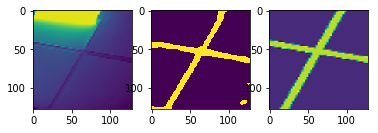

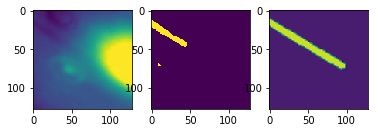

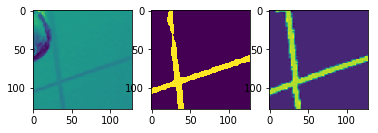

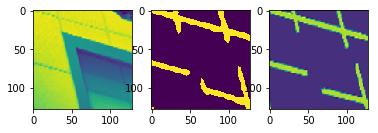

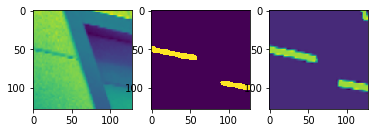

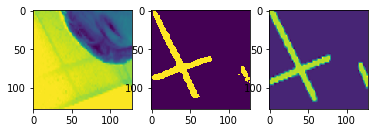

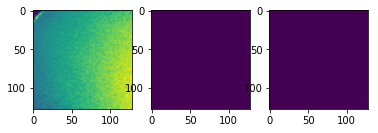

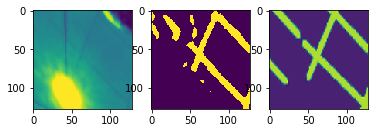

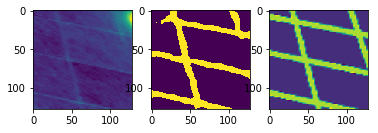

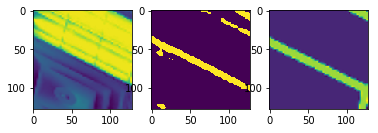

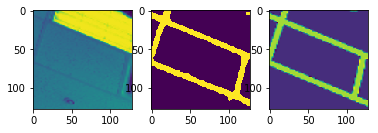

In [376]:
#augment by rotation
angle = np.random.randint(360)
print(angle)
batchx = scipy.ndimage.interpolation.rotate(data, angle, (1, 2), False, mode="constant", cval=0)
batchy = scipy.ndimage.interpolation.rotate(y_edge, angle, (1, 2), False, mode="constant", cval=-1)


batchx = np.concatenate([batchx, np.flip(batchx, 2)])
batchy = np.concatenate([batchy, np.flip(batchy, 2)])


offset = np.random.random((len(batchx), 1, 1, 1)) / 4 - .125
scale = np.random.random((len(batchx), 1, 1, 1)) / 2 + .75
batchx = batchx.copy()


batchx = scale * batchx + offset
#batchx = np.concatenate([batchx, -batchx]) / 255.


maxcrop = 90
shape = batchx[0].shape

final_x = []
final_y = []
for i in range(len(batchx)):

    while True:

        x1 = np.random.randint(0, maxcrop)
        x2 = np.random.randint(256 - maxcrop, 256)

        y1 = np.random.randint(0, maxcrop)
        y2 = np.random.randint(256 - maxcrop, 256)



        y_test = batchy[i, x1:x2, y1:y2]

        if not(np.any(y_test == -1)):
            break

    final_x.append(cv2.resize(batchx[i, x1:x2:2, y1:y2:2], (128, 128)))
    final_y.append(cv2.resize(batchy[i, x1:x2:2, y1:y2:2], (128, 128)))


batchx = np.array(final_x)
batchy = np.array(final_y)

batchy = np.expand_dims(batchy, -1)
batchy = np.concatenate([batchy, 1-batchy], -1)

print(batchx.shape, batchy.shape)



print(_, l)
for i in range(0, 400, 5):
    plt.subplot(1, 3, 1)
    plt.imshow(batchx[i, :, :, 0])
    #plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(models[0].predict(batchx[i:i+ 1]).reshape((-1, patch_size, patch_size, 2))[0, :, :, 0] > .5)
    #plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(batchy.reshape((-1, patch_size, patch_size, 2))[i, :, :, 0])
    
    #plt.colorbar()
    plt.show()

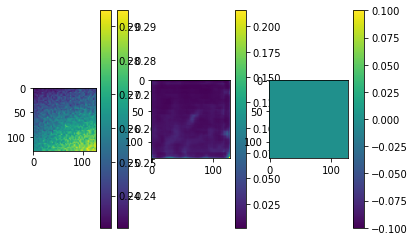

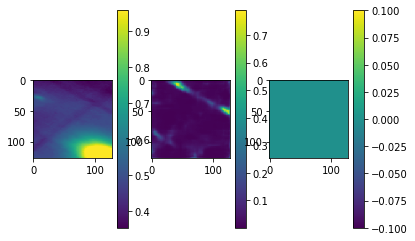

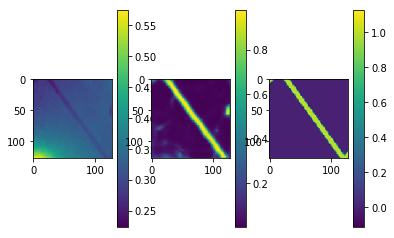

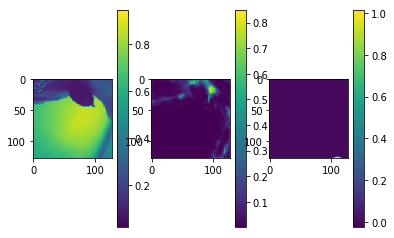

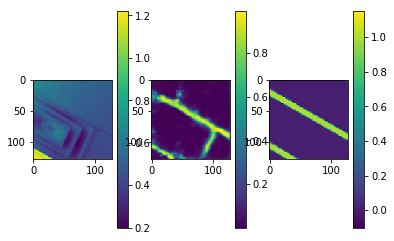

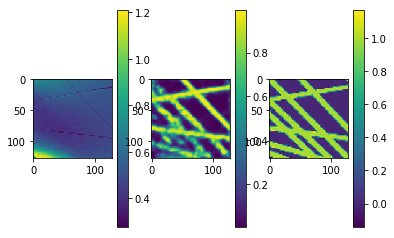

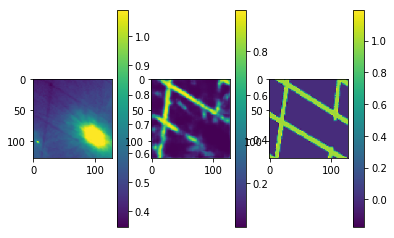

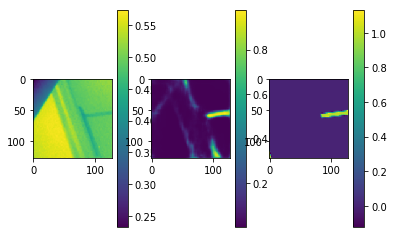

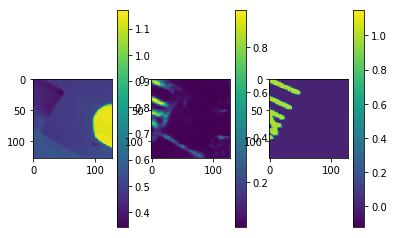

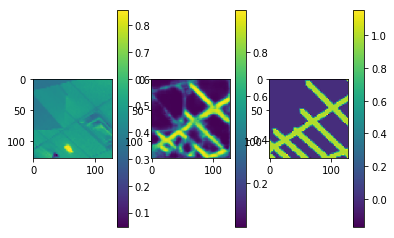

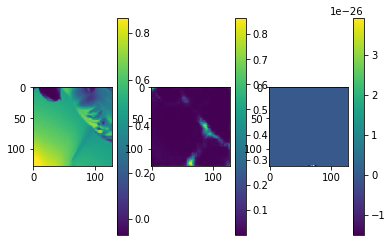

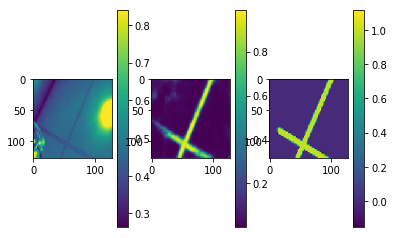

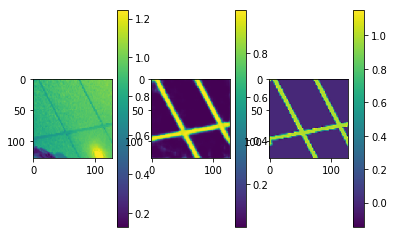

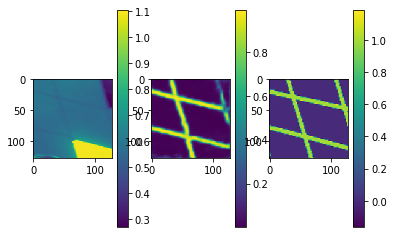

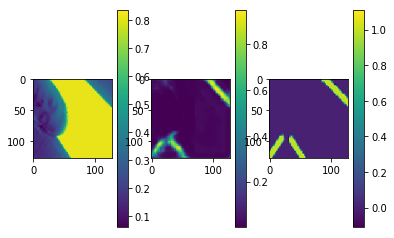

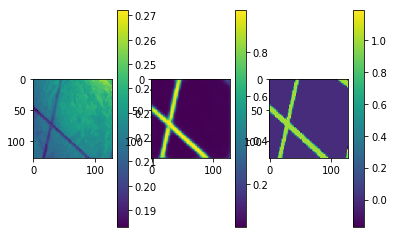

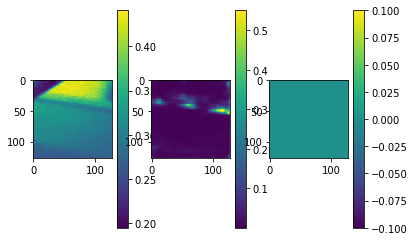

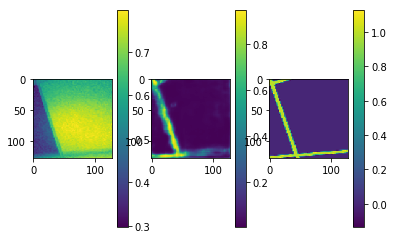

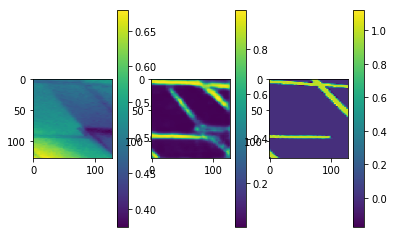

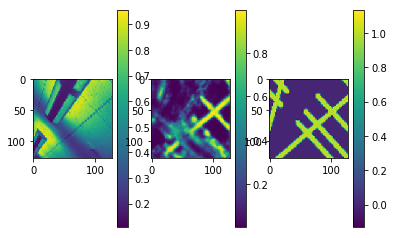

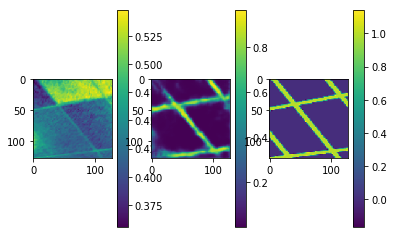

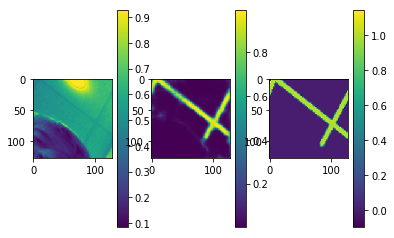

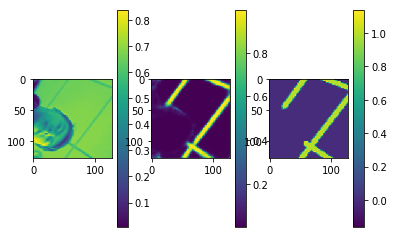

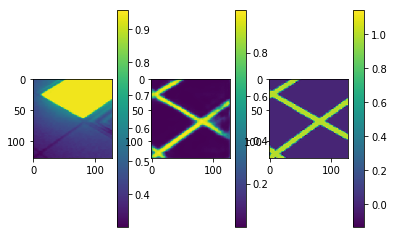

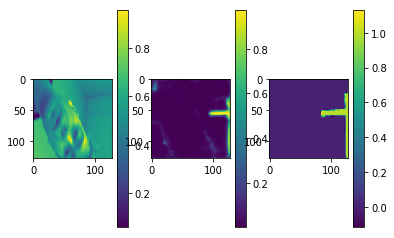

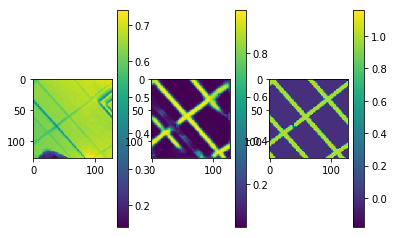

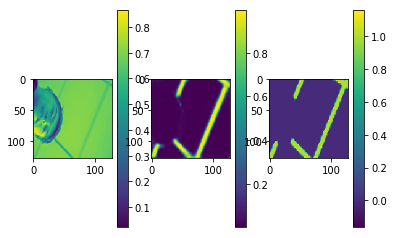

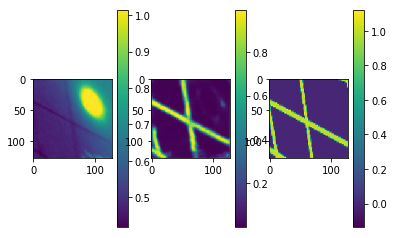

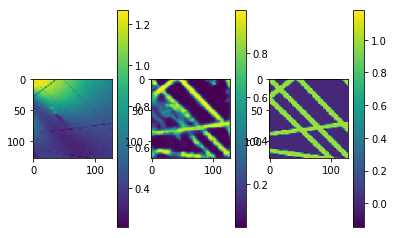

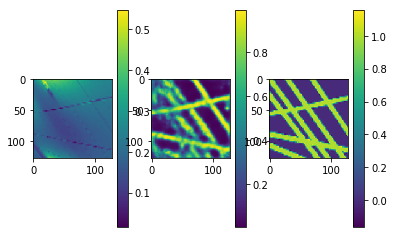

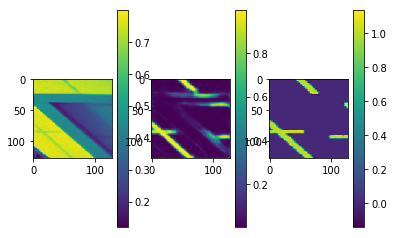

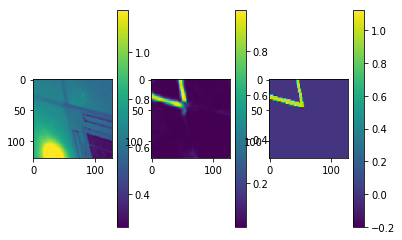

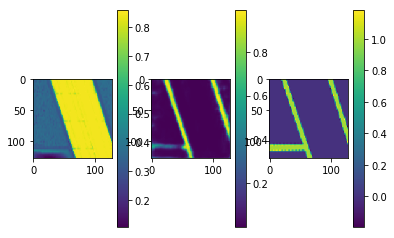

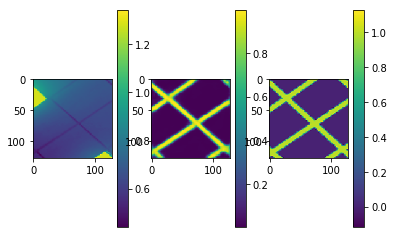

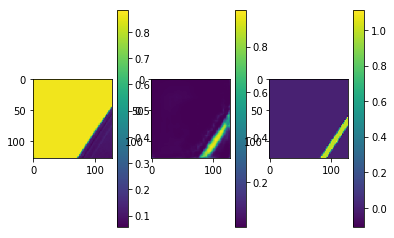

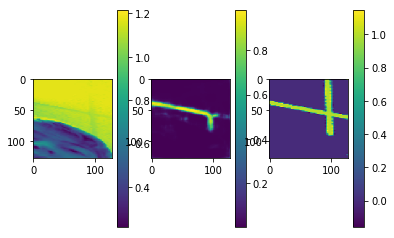

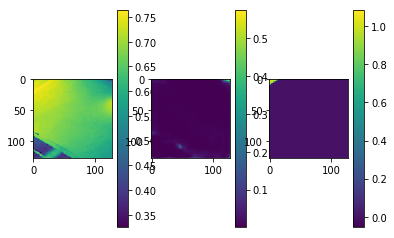

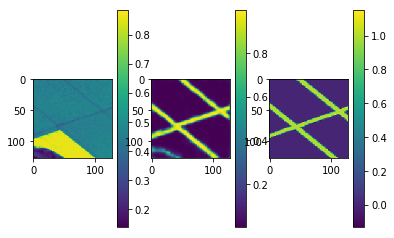

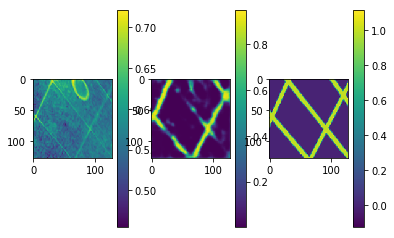

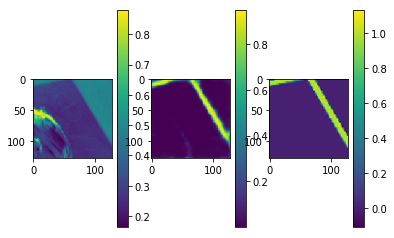

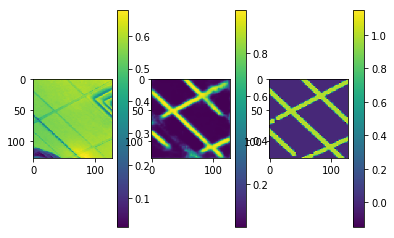

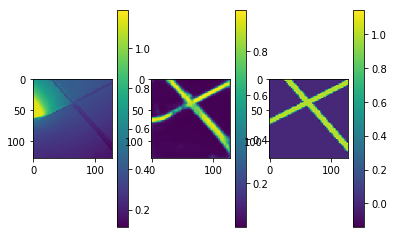

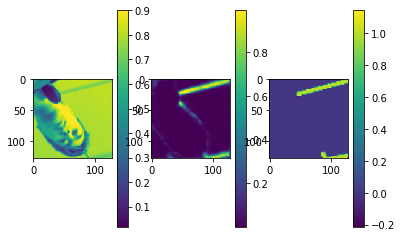

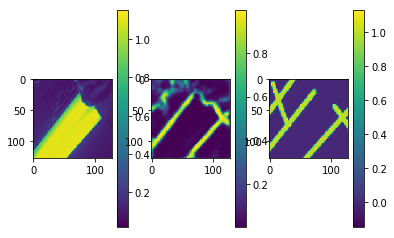

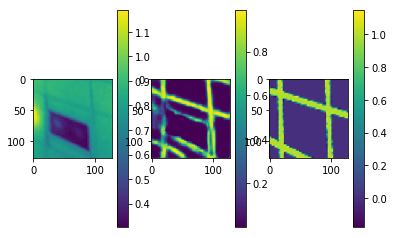

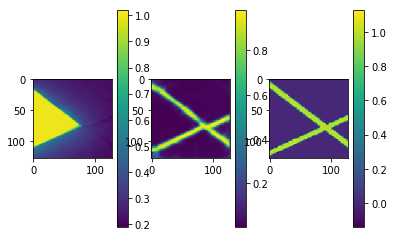

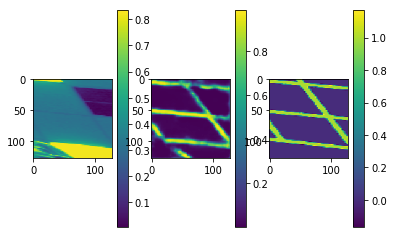

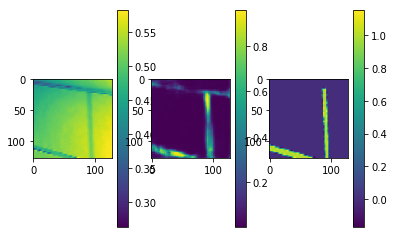

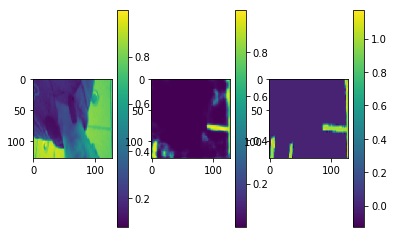

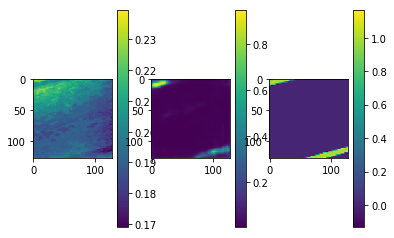

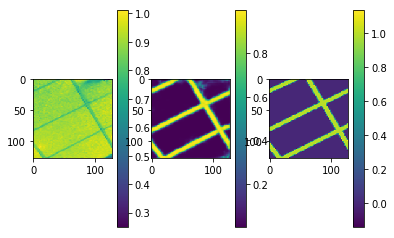

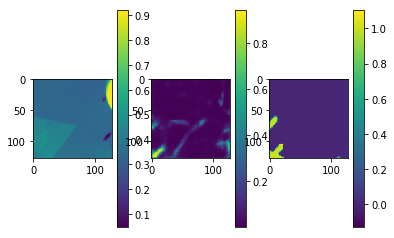

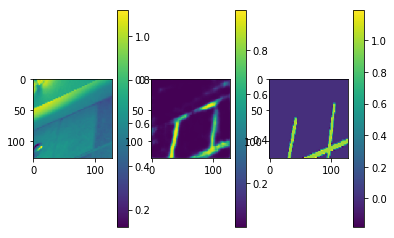

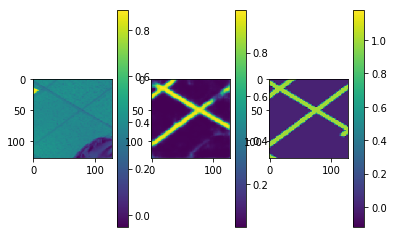

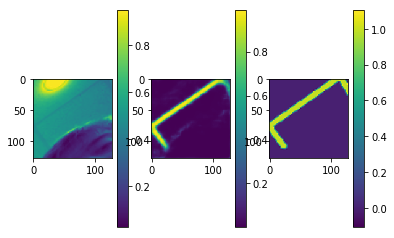

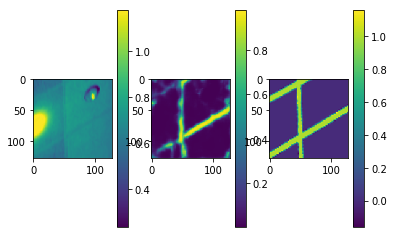

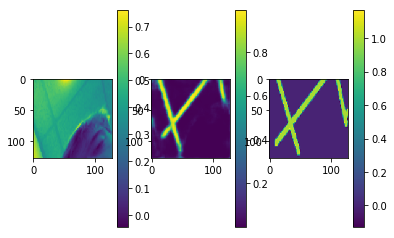

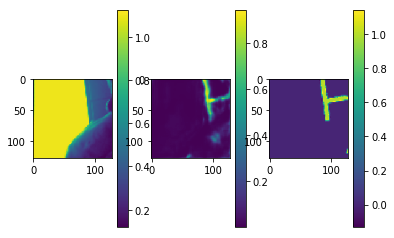

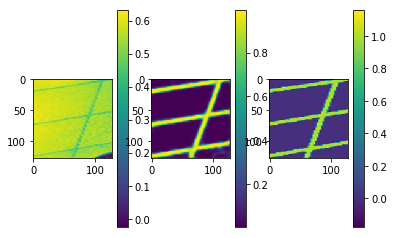

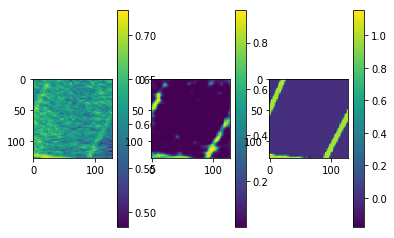

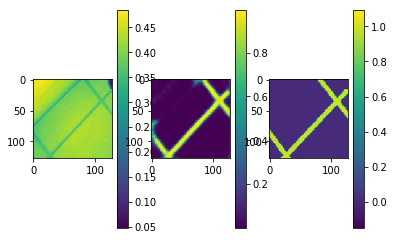

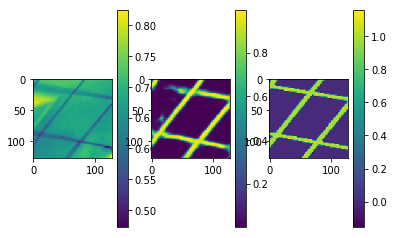

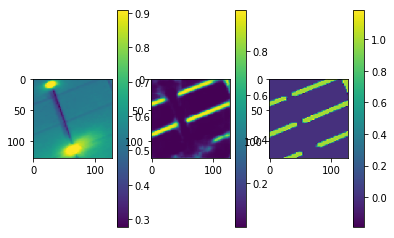

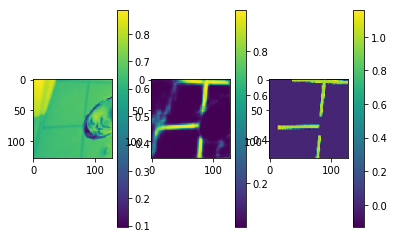

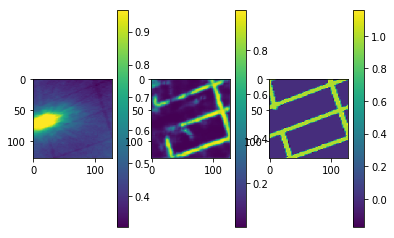

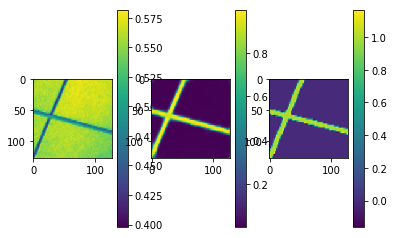

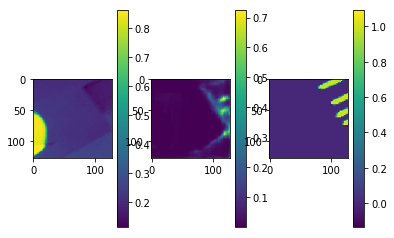

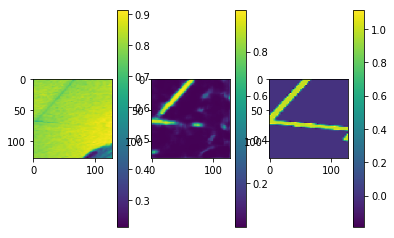

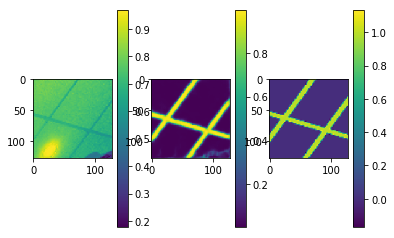

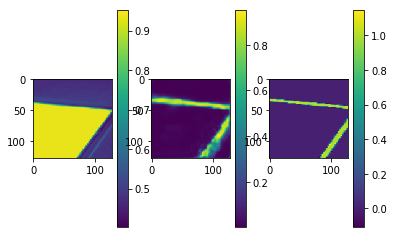

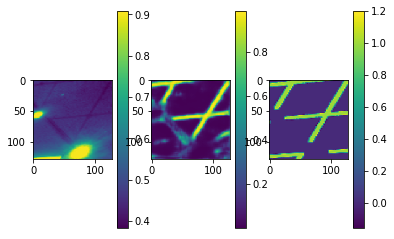

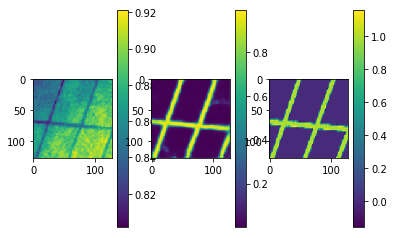

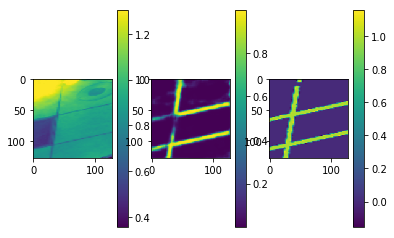

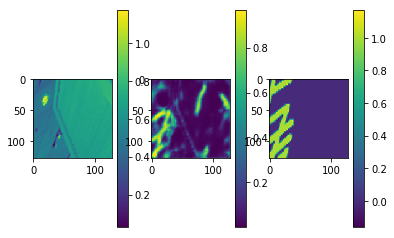

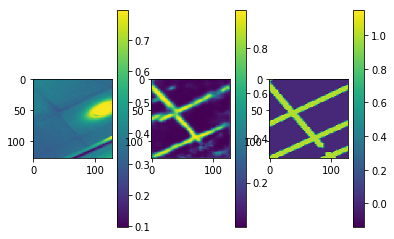

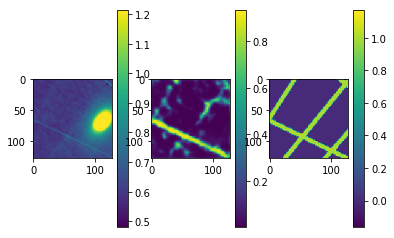

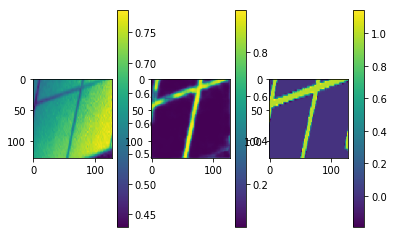

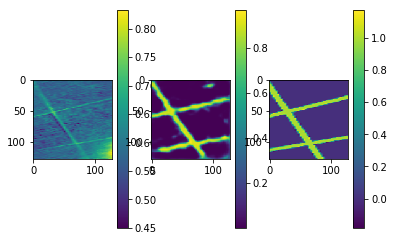

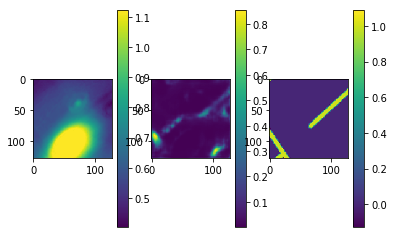

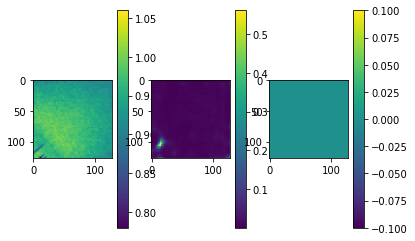

In [58]:
for i in range(0, 400, 5):
    plt.subplot(1, 3, 1)
    plt.imshow(batchx[i, :, :, 0])
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(models[0].predict(batchx[i:i+ 1]).reshape((-1, patch_size, patch_size, 2))[0, :, :, 0])
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(batchy.reshape((-1, patch_size, patch_size, 2))[i, :, :, 0])
    
    plt.colorbar()
    plt.show()

In [209]:
model.test_on_batch(batchx, batchy)

0.1456868

In [210]:
model.loss_functions

[<function keras.losses.mean_squared_error>]

In [82]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = 15, 15

In [366]:
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_154 (Conv2D)              (None, 64, 64, 5)     380         input_12[0][0]                   
____________________________________________________________________________________________________
conv2d_155 (Conv2D)              (None, 32, 32, 10)    460         conv2d_154[0][0]                 
____________________________________________________________________________________________________
conv2d_156 (Conv2D)              (None, 16, 16, 21)    1911        conv2d_155[0][0]                 
___________________________________________________________________________________________

In [4]:
plt.imshow(np.all(classes[6] == np.array([[[36, 28, 237]]]), axis=2))
plt.show()

c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


AxisError: axis 2 is out of bounds for array of dimension 0

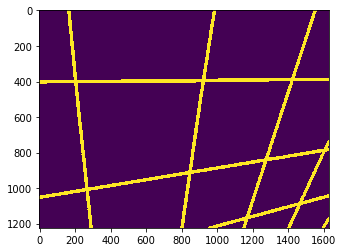

In [12]:
plt.imshow(y_edge[12])
plt.show()

In [66]:
%matplotlib inline

In [67]:
pictures2 = [cv2.imread("allframes/"+name)[::2, ::2] for name in os.listdir("allframes")[::7]]

In [84]:
for i in range(len(pictures2)):
    plt.subplot()
    plt.imshow(model.predict(np.expand_dims(pictures2[i] / 255., 0)[:128,1000:1128])[0].reshape((128, 128, 2))[:, :, 0])
    plt.colorbar()
    plt.show()
    plt.imshow(pictures2[i][1000:1128, :128])
    plt.show()

ValueError: Error when checking : expected input_1 to have shape (None, 128, 128, 3) but got array with shape (1, 0, 432, 3)

In [4]:
test = cv2.imread("test/IMG_0980.JPG")
test = test[::4, ::4]

In [672]:
test

array([[[ 59,  66,  69],
        [ 62,  69,  72],
        [ 65,  72,  75],
        ..., 
        [ 79,  83,  78],
        [ 82,  86,  81],
        [ 85,  89,  84]],

       [[ 62,  69,  72],
        [ 64,  71,  74],
        [ 65,  72,  75],
        ..., 
        [ 82,  86,  81],
        [ 84,  88,  83],
        [ 87,  91,  86]],

       [[ 71,  78,  81],
        [ 67,  74,  77],
        [ 63,  70,  73],
        ..., 
        [ 84,  88,  83],
        [ 85,  89,  84],
        [ 87,  91,  86]],

       ..., 
       [[105, 113, 120],
        [106, 114, 121],
        [106, 114, 121],
        ..., 
        [143, 146, 160],
        [143, 146, 160],
        [142, 145, 159]],

       [[103, 111, 118],
        [103, 111, 118],
        [102, 110, 117],
        ..., 
        [143, 146, 160],
        [143, 146, 160],
        [142, 145, 159]],

       [[102, 110, 117],
        [103, 111, 118],
        [100, 108, 115],
        ..., 
        [143, 146, 160],
        [143, 146, 160],
        [143, 146,

In [5]:
pictures2 = [test[::7, ::7]]

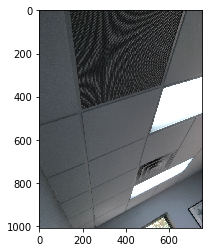

In [6]:
plt.imshow(test)
plt.show()

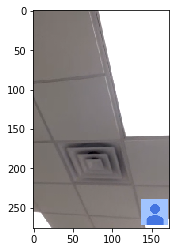

too many
(15,)


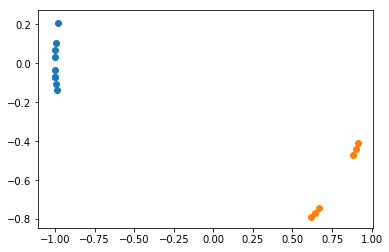

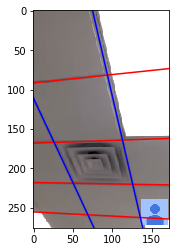

In [124]:
def process(test, liveCV=False, graph=False):
    img = np.array(segment3(test, graph=graph))
    gray = img
    if liveCV:
        cv2.imshow('nn',img)
    #edges = np.logical_or(img[2:, 1:-1] != img[:-2, 1:-1],  img[1:-1, :-2] != img[1:-1, 2:])
    from skimage import img_as_bool, io, color, morphology
    import matplotlib.pyplot as plt

    edges = morphology.skeletonize(img)
    if graph:
        plt.imshow(edges)
        plt.show()
    edges = edges.astype(np.uint8)

    img = np.array(test)

    lines = cv2.HoughLines(edges,1,np.pi/180,40)
    if lines is not None and len(lines) > 25:
        lines = cv2.HoughLines(edges,1,np.pi/180,50)
        print("too many")
    
    return lines

def cvShow(lines, img):
    
    if lines is not None and len(lines.shape) == 3:
        print(lines.shape)
        for rho,theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 2000*(-b))
            y1 = int(y0 + 2000*(a))
            x2 = int(x0 - 2000*(-b))
            y2 = int(y0 - 2000*(a))

            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    
    cv2.imshow('nn',img)
    return img
        
def segment3(line, graph=True):
    inp = line
    offset = (patch_size - 100) // 2
    line = np.pad(line, ((offset, offset + patch_size //2 + 100),
                         (offset, offset + patch_size //2 + 100),
                         (0, 0)), "reflect")
    shape = line.shape
    
    i_grid, j_grid = np.mgrid[0:shape[0] - patch_size:128, 0:shape[1]-patch_size:128]
    
    B_shape = i_grid.shape
    
    i_grid = i_grid.flatten()
    j_grid = j_grid.flatten()
    blbatch = np.array([
        line[ci:ci + patch_size, cj:cj + patch_size] for ci, cj in zip(i_grid, j_grid)
    ])
    
    
    res = model.predict(blbatch)
    #classes = res[:, :, 0]
    classes = np.argmax(res, -1)
    classes = classes.reshape((B_shape[0] * B_shape[1], 128, 128))
    
    result = np.zeros(line.shape[:-1])
    
    for i, j, block in zip(i_grid, j_grid, classes):
        offset = (patch_size - 100) // 2
        result[i:i + patch_size, j:j + patch_size] = block
    
    
    result = result[offset:offset + inp.shape[0], offset:offset + inp.shape[1]]
    if graph:
        #relevantRegion = line[ patch_size // 4:np.max(i_grid) + patch_size * 3 // 4, patch_size //4 :np.max(j_grid) + patch_size* 3 // 4]
        plt.imshow(inp , cmap="gray")
        #plt.show()
        plt.imshow(result, alpha=.5)
    
        plt.show()
        print(result.shape, line.shape)
        #plt.show()
        
    return result

def lineFromRhoTheta(rt):
    x = []
    y = []

    if lines is not None:
        for rho,theta in rt[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = (x0 + 800*(-b))
            y1 = (y0 + 800*(a))
            x2 = (x0 - 800*(-b))
            y2 = (y0 - 800*(a))
            x.append([x1, x2])
            y.append([y1, y2])
            
    x = np.array(x)
    y = np.array(y)
    return x, y

from sklearn.cluster import AffinityPropagation, k_means
from sklearn import mixture
def reduce(lines):
    if lines is not None:
        af = AffinityPropagation(preference=-.01)
        af.fit(lines[:, 0] / np.array([[300, 1]]))

        real_lines = af.cluster_centers_ * np.array([[300, 1]])
        return np.expand_dims(real_lines, 1)
    
    
def split(lines):
    if lines is not None:
        idxs = np.arange(len(lines))
        angles = lines[:, 0, 1] * 2
        vangles = np.array([np.cos(angles), np.sin(angles)]).transpose()

        clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
        clf.fit(vangles)
        label = clf.predict(vangles)
        print(label.shape)
        l1 = lines[label == 0]
        l2 = lines[label == 1]
        plt.scatter(vangles[label == 0, 0], vangles[label == 0, 1])
        plt.scatter(vangles[label == 1, 0], vangles[label == 1, 1])
        plt.show()
        return l1, l2
    return None, None
    
import random
test = random.choice(imgs2)[0]
plt.imshow(test)
plt.show()

dialation = 1
lines = process(test[::dialation, ::dialation], graph=False)

l1, l2 = split(lines)
#for l in l1, l2:
#    plt.scatter(l[:, 0, 0], l[:, 0, 1])
#plt.show()

for l, color in zip([l1, l2], ["red", "blue"]):
    xt, yt = lineFromRhoTheta(reduce(l))
    plt.plot(xt.transpose(), yt.transpose(), c=color)
plt.imshow(test[::dialation, ::dialation])
plt.show()


In [34]:
k_means?

In [125]:
import pickle
pickle.dump(imgs2, open("testdata", "wb"))

too many


AttributeError: module 'numpy' has no attribute 'arrange'

In [509]:
lines

array([[[ 115.        ,    1.86750233]]], dtype=float32)

array([[[ 225.        ,    1.2915436 ]],

       [[  49.        ,    2.37364769]],

       [[ 117.        ,    2.28638124]],

       [[ 264.        ,    1.39626336]],

       [[ 263.        ,    1.41371667]],

       [[  46.        ,    2.39110112]],

       [[ 167.        ,    1.13446403]],

       [[  52.        ,    2.3561945 ]],

       [[  72.        ,    0.92502451]],

       [[ 166.        ,    1.15191734]],

       [[ 120.        ,    2.26892805]],

       [[ 115.        ,    2.30383468]],

       [[  73.        ,    0.89011788]],

       [[ -57.        ,    2.51327419]]], dtype=float32)

In [126]:
run ../getLines.py

OSError: Unable to open file (Unable to open file: name = 'line detector/mediocre_linefinder', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [358]:
plt.plot(loss)
plt.show()

TypeError: float() argument must be a string or a number, not 'History'

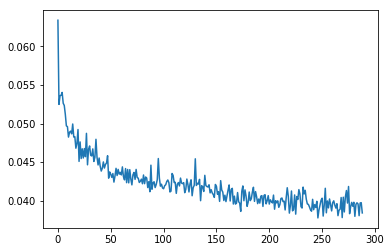

In [36]:
plt.plot(loss)
plt.show()

In [56]:
from PIL import ImageGrab
bb = [1546, 397, 2065, 1223]
while True:
    test = np.array(ImageGrab.grab(bb))
    lines = reduce(process(test[::3, ::3], liveCV=True))
    res = cvShow(lines, test[::3, ::3].copy())
    imgs2.append([test[::3, ::3].copy(), res])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        
        break

In [78]:

imgs2 = []

(5, 1, 2)
(5, 1, 2)
(7, 1, 2)
(7, 1, 2)
too many
(6, 1, 2)
(7, 1, 2)
(7, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(5, 1, 2)
(6, 1, 2)
(5, 1, 2)
(6, 1, 2)
(6, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(4, 1, 2)
(6, 1, 2)
(3, 1, 2)
(7, 1, 2)
(6, 1, 2)
(3, 1, 2)
(6, 1, 2)
(5, 1, 2)
(5, 1, 2)
(5, 1, 2)
(7, 1, 2)
(4, 1, 2)
(2, 1, 2)
(4, 1, 2)
(2, 1, 2)
(6, 1, 2)
(5, 1, 2)
(5, 1, 2)
(6, 1, 2)
(5, 1, 2)
too many
(8, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
(6, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(6, 1, 2)
(4, 1, 2)
(6, 1, 2)
(6, 1, 2)
(5, 1, 2)
(5, 1, 2)
(4, 1, 2)
(4, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(6, 1, 2)
(5, 1, 2)
(6, 1, 2)
(6, 1, 2)
(6, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(8, 1, 2)
(6, 1, 2)
(8, 1, 2)
too many
(5, 1, 2)
(6, 1, 2)
too many
(7, 1, 2)
too many
(6, 1, 2)
(8, 1, 2)
(6, 1, 2)
(5, 1, 2)
(6, 1, 2)
too many
(5, 1

c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\sklearn\cluster\affinity_propagation_.py:134: RuntimeWarning: invalid value encountered in subtract
  tmp -= np.sum(tmp, axis=0)
c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\sklearn\cluster\affinity_propagation_.py:145: RuntimeWarning: invalid value encountered in greater
  E = (np.diag(A) + np.diag(R)) > 0
c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\sklearn\cluster\affinity_propagation_.py:161: RuntimeWarning: invalid value encountered in greater
  I = np.where(np.diag(A + R) > 0)[0]


(2, 1, 2)
(1, 1, 2)
(1, 1, 2)
(6, 1, 2)
(8, 1, 2)
(7, 1, 2)
(6, 1, 2)
(6, 1, 2)
(8, 1, 2)
(7, 1, 2)
(6, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(7, 1, 2)
(7, 1, 2)
(5, 1, 2)
(7, 1, 2)
(8, 1, 2)
(8, 1, 2)
(6, 1, 2)
(6, 1, 2)
(8, 1, 2)
(7, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(8, 1, 2)
(7, 1, 2)
(7, 1, 2)
(7, 1, 2)
(8, 1, 2)
(7, 1, 2)
(7, 1, 2)
(7, 1, 2)
(7, 1, 2)
(8, 1, 2)
(7, 1, 2)
(7, 1, 2)
(7, 1, 2)
(8, 1, 2)
(4, 1, 2)
(5, 1, 2)
(6, 1, 2)
too many
(7, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
too many
(5, 1, 2)
too many
(7, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
(5, 1, 2)
too many
(5, 1, 2)
(5, 1, 2)
too many
(6, 1, 2)
too many
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(6, 1, 2)
(5, 1, 2)
(6, 1, 2)
(7, 1, 2)
(8, 1, 2)
too many
(8, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
too many
(7, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(6, 1, 2)
(7, 1, 2)
(7, 1, 2)
(7, 1, 2)
(4, 1, 2)
(6, 1, 2)
(4, 1, 2)
(6, 1, 2)
(4, 1, 2)
(4, 1, 2)
(3, 1, 2)
(3, 1, 2)
(2, 1, 2)
(3, 1, 2)
(3

KeyboardInterrupt: 

In [80]:
len(imgs2)

335

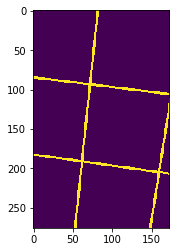

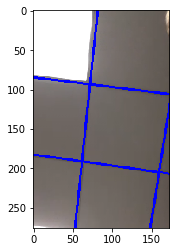

In [555]:
plt.imshow(np.all(imgs[400][1] == np.array([[0, 0, 255]]), axis=2))
plt.show()
plt.imshow(imgs[400][1])
plt.show()

In [564]:
imgs = np.array(imgs)

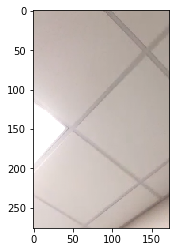

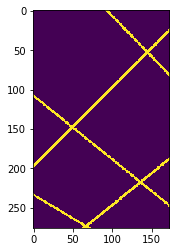

In [704]:

plt.imshow(bdata[0])
plt.show()
plt.imshow(bclasses[0])
plt.show()

In [659]:
loss = []
model = unet(2, True, input_dim=3)
model.compile(rmsprop(), keras.losses.categorical_crossentropy)

(?, 64, 64, 32) (?, 128, 128, 32)
(?, 32, 32, 128) (?, 64, 64, 128)
(?, 16, 16, 256) (?, 32, 32, 256)
(?, 8, 8, 256) (?, 16, 16, 256)
(?, 4, 4, 512) (?, 8, 8, 512)
8 8
16 16
32 32
64 64
128 128
(?, 128, 128, 2)


In [67]:
import scipy

for width in [9, 8, 6, 3, 3,3,3,33, 3, 3, 3, 3, 3, 3]:
    width = 3
    for _ in range(770):
        #y_edge = np.logical_or(y[:, 2:, 1:-1] != y[:, :-2, 1:-1], 0)
        batch = imgs[np.random.choice(range(len(imgs)), 23)]
        data = batch[:, 0] / 255
        classes = np.all(batch[:, 1] == np.array([[0, 0, 255]]), axis=3)
        y_edge = np.array([scipy.ndimage.binary_dilation(y_e, iterations=width) for y_e in classes])
        
        shape = data[0].shape
        cropi = np.random.randint(0, shape[0] - patch_size, len(data))
        cropj = np.random.randint(0, shape[1] - patch_size, len(data))
        batchx = [
            xn[ci:ci + patch_size, cj:cj + patch_size] for xn, ci, cj in zip(data, cropi, cropj)
        ]
        batchy = np.array([
            yn[ci:ci + patch_size, cj:cj + patch_size] for yn, ci, cj in zip(y_edge, cropi, cropj)
        ])
        angle = np.random.randint(360)
        print(angle)
        #batchx = scipy.ndimage.interpolation.rotate(batchx, angle, (1, 2), False, mode="reflect")
        offset = np.random.random(len(batchx)) / 4 - .125
        scale = np.random.random(len(batchx)) / 2 + .75
        batchx = np.reshape(scale, [23, 1, 1, 1]) * batchx + np.reshape(offset, [23, 1, 1, 1])
        batchx = np.concatenate([batchx, np.flip(batchx, 2)])
        #batchx = np.concatenate([batchx, -batchx]) / 255.
        #batchy = scipy.ndimage.interpolation.rotate(batchy, angle, (1, 2), False, mode="reflect", order=0)
        batchy = np.concatenate([batchy, np.flip(batchy, 2)])
        #batchy = np.concatenate([batchy, batchy])
        


        batchy = keras.utils.to_categorical(batchy, num_classes=2)

        batchy = batchy.reshape([len(batchx), patch_size**2, -1])

        l = model.train_on_batch(batchx, batchy)
        loss.append(l)
        print(_, l)

TypeError: only integer scalar arrays can be converted to a scalar index

In [375]:

batch = imgs[np.random.choice(range(len(imgs)), 23)]
data = batch[:, 0] / 255
classes = np.all(batch[:, 1] == np.array([[0, 0, 255]]), axis=3)
y_edge = np.array([scipy.ndimage.binary_dilation(y_e, iterations=width) for y_e in classes])

shape = data[0].shape
cropi = np.random.randint(0, shape[0] - patch_size, len(data))
cropj = np.random.randint(0, shape[1] - patch_size, len(data))
batchx = [
    xn[ci:ci + patch_size, cj:cj + patch_size] for xn, ci, cj in zip(data, cropi, cropj)
]
batchy = np.array([
    yn[ci:ci + patch_size, cj:cj + patch_size] for yn, ci, cj in zip(y_edge, cropi, cropj)
])
angle = np.random.randint(360)
print(angle)
#batchx = scipy.ndimage.interpolation.rotate(batchx, angle, (1, 2), False, mode="reflect")
offset = np.random.random(len(batchx)) / 4 - .125
scale = np.random.random(len(batchx)) / 2 + .75
batchx = np.reshape(scale, [23, 1, 1, 1]) * batchx + np.reshape(offset, [23, 1, 1, 1])
batchx = np.concatenate([batchx, np.flip(batchx, 2)])
#batchx = np.concatenate([batchx, -batchx]) / 255.
#batchy = scipy.ndimage.interpolation.rotate(batchy, angle, (1, 2), False, mode="reflect", order=0)
batchy = np.concatenate([batchy, np.flip(batchy, 2)])
#batchy = np.concatenate([batchy, batchy])



batchy = keras.utils.to_categorical(batchy, num_classes=2)

batchy = batchy.reshape([len(batchx), patch_size**2, -1])

l = model.train_on_batch(batchx, batchy)
loss.append(l)
print(_, l)
print(_, l)
for i in range(0, 64):
    plt.subplot(1, 3, 1)
    plt.imshow(batchx[i, :, :, 0])
    
    plt.subplot(1, 3, 2)
    plt.imshow(model.predict(batchx[i:i+ 1]).reshape((-1, patch_size, patch_size, 2))[0, :, :, 0])
    #plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(batchy.reshape((-1, patch_size, patch_size, 2))[i, :, :, 0])
    
    #plt.colorbar()
    plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

In [613]:
patch_size

128

In [65]:
model.save("../web_linefinder")

In [357]:
model.save("../heavy_linefinder")

In [442]:
models[5].save("../light_diverse_linefinder")

In [443]:
umodel = keras.models.load_model("../heavy_linefinder")

In [85]:
models[1].save("../light_more_diverse_linefinder")

In [222]:
models[0].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 16)    1216        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 32)    4640        conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 16, 16, 64)    18496       conv2d_2[0][0]                   
___________________________________________________________________________________________

In [223]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_29 (Conv2D)               (None, 64, 64, 5)     140         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_30 (Conv2D)               (None, 32, 32, 10)    460         conv2d_29[0][0]                  
____________________________________________________________________________________________________
conv2d_31 (Conv2D)               (None, 16, 16, 21)    1911        conv2d_30[0][0]                  
___________________________________________________________________________________________

In [387]:
models[0].save("../heavy_diverser_linefinder")